# Imports + Helper Funcions

## Imports

In [135]:
#DELETAR SE NÃO USADOS:
#import math
#import inflection
#from tabulate              import tabulate
#import datetime as dt
#from scipy                 import stats

import pandas as pd 
import datetime as dt
from IPython.core.display  import HTML
from matplotlib            import pyplot as plt
from IPython.display       import Image
import numpy as np
import seaborn as sns

#DEVEM SER USADOS:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import pickle
from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb
# import random
# from datetime              import timedelta



## Helper Functions

In [156]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizanod tamanhos de plots, etc """
    %matplotlib inline
    #%pylab inline - not recommended
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 45)
    pd.set_option('display.max_rows', 45)
jupyter_settings()


def ml_error( model_name, y, yhat ):
    """ Calcula os erros do modelo passado 
    model_name: nome do modelo
             y: valores de vendas reais
          yhat: valores de vendas estimados pelo modelo """
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse  }, index=[0] )



#Apenas para tareafs envolvendo time series, em função do kfold.
def cross_validation( x_training, kfold , model_name, model, verbose=False):
    """Calcula a performance real de um modelo passado via parâmetro.
    model recebe o modelo já instanciado.
    Passo só os dados de treino, e irá dividir o dataset em treino e validação 
         conforme o número de divisões passado via 'kfoln'.
    Irá a partir disso criar os datasets de validação de 6 semanas a cada iteração.
    Irá então treinar o modelo passado, e o modelo fará a previsão de vendas.
    Irá então chamar a função ml_erros, que calcula o erro do modelo.
    Retorna a performance real do modelo (erros: 'MAE','MAPE','RMSE') ± 1 std."""
    
    mae_list = []
    mape_list = []
    rmse_list = []

    k = 1
    for k in reversed (range(1,kfold+1) ):
        
        validation_start_date = x_training['date'].max() - dt.timedelta( days=k*6*7 ) 
        validation_end_date = x_training['date'].max() - dt.timedelta( days=(k-1)*6*7 )

        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date) ]

        if verbose: 
            print('\nKFold Number: ',k)
            print('kFold training start date: ',training['date'].min() )
            print('kFold training end date: ',training['date'].max() )
            print('kFold validation start date: ',validation_start_date)
            print('kFold validation end date: ',validation_end_date)
            
        
        #training and validation dataset:
        # vou excluir agora as colunas date e sales para treino e validação:  
        xtraining = training.drop( ['date','sales'], axis=1 )#features
        ytraining = training['sales']#variável resposta            
        xvalidation = validation.drop( ['date','sales'], axis=1 ) #features
        yvalidation = validation['sales']#variável resposta

        #model training (sobre os dados de treino)
        m = model.fit( xtraining, ytraining )

        #model prediction (sobre os dados de validação)
        yhat = m.predict ( xvalidation )

        #performance
        m_result = ml_error ( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] ) 

    #cria dicionário calculando a média e std de cada erro, 
    #e já retorna um df pronto com a performance do modelo no formato: (erro ± 1 std):
    return pd.DataFrame ( {
        'Model Nme': model_name,
        'MAE CV': np.round(np.mean( mae_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mae_list),2 ).astype( str ),
        'MAPE CV': np.round(np.mean( mape_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mape_list),2 ).astype( str ),
        'RMSE CV': np.round(np.mean( rmse_list),2 ).astype( str ) + ' ± ' + np.round(np.std( rmse_list),2 ).astype( str ) }, index=[0] )


# Passo 05 - Data Preparation

## Checkpoint [1]

É possível retormar o projeto a partir daqui.

In [3]:
                                                    # lê todo o arquivo de uma vez 
df5 = pd.read_csv("../data/4_exploratory_data_analysis_done.csv", low_memory=False)

In [5]:
df5.shape #correto!

(844338, 29)

In [6]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [7]:
df5.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
promo_interval                   object
month_map                        object
is_promo                          int64
year                              int64
month                             int64
day                               int64
week_of_year                      int64
year_week                        object


In [8]:
#Converter 'date' de obj para datetieme (por causo da leitura do arquivo, vem como object)
df5['date'] = pd.to_datetime(df5['date'] )
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

## Normalização

Vamos primieramente avaliar quais variáveis serão normalizadas, olhando suas distribuições em EDA -> Análise Univariada -> Numerical Variable.

Notamos lá nos histogramas que não temos nenhuma variável com distribuição normal, logo não vamos normalizar nada neste projeto, e vamos fazer reescaling de todas as variáveis. 

## Rescaling

Identificar primeiramente as variáveis que vamos aplicar o rescaling.
Selecionar as variáveis numéricas:

In [10]:
a = df5.select_dtypes ( include=['int64','float64'] )

In [11]:
a.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo2_time_week
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Variáveis que vamos aplicar o rescaling estão listadas abaixo, e as de natureza cíclica foram encaminhadas para o Transformation de natureza cíclica mais abaixo.

In [ ]:
#competition_distance = distância em metros do consumidor mais próximo
#competition_time_month = há quantos meses a competição iniciou
#promo2_time_week = tempo em que a promoção ficou ativa em semanas
#year = é o ano da data de venda

Qual técnica escolher?
Se poucos outliers, aplicar Min Max Scaler.
Se muitos outliers, aplicar Robust Scaler.

Vamos analisar cada variável:

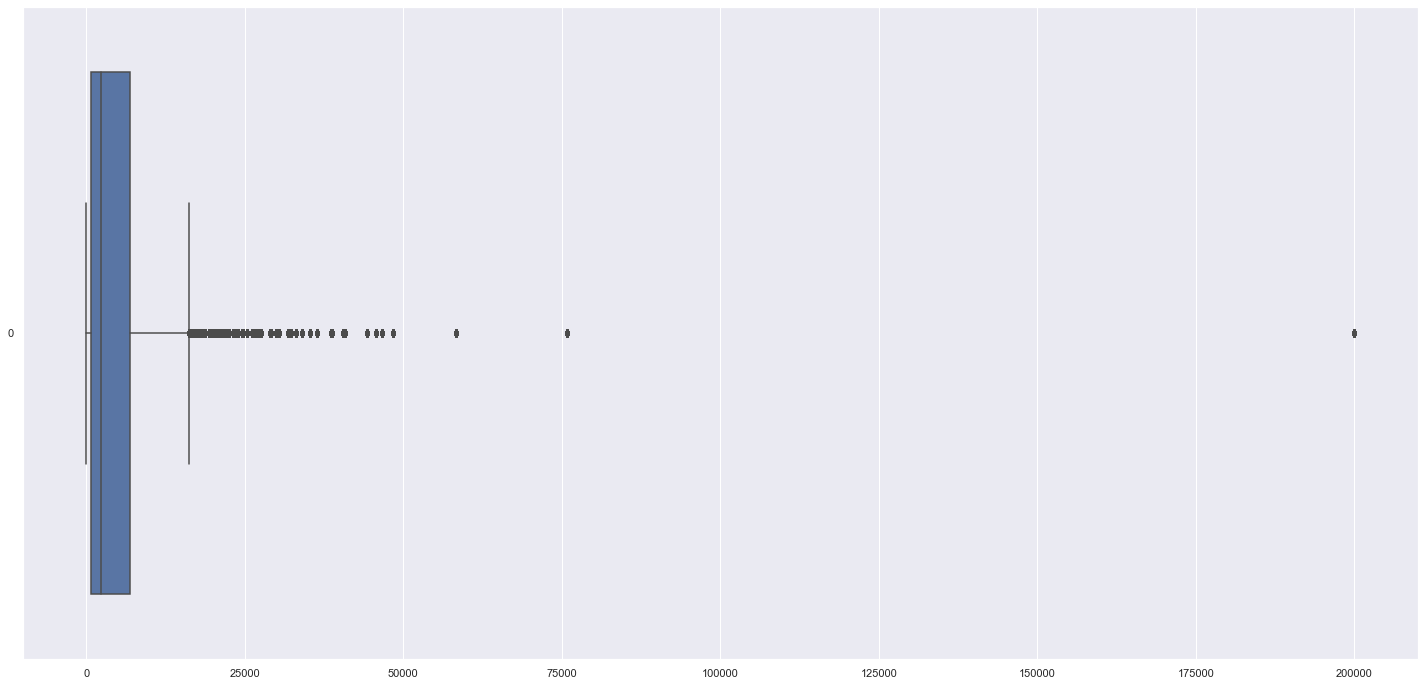

In [14]:
sns.boxplot(data= df5['competition_distance'], orient='h' ); #tem muitos outliers -> Robust

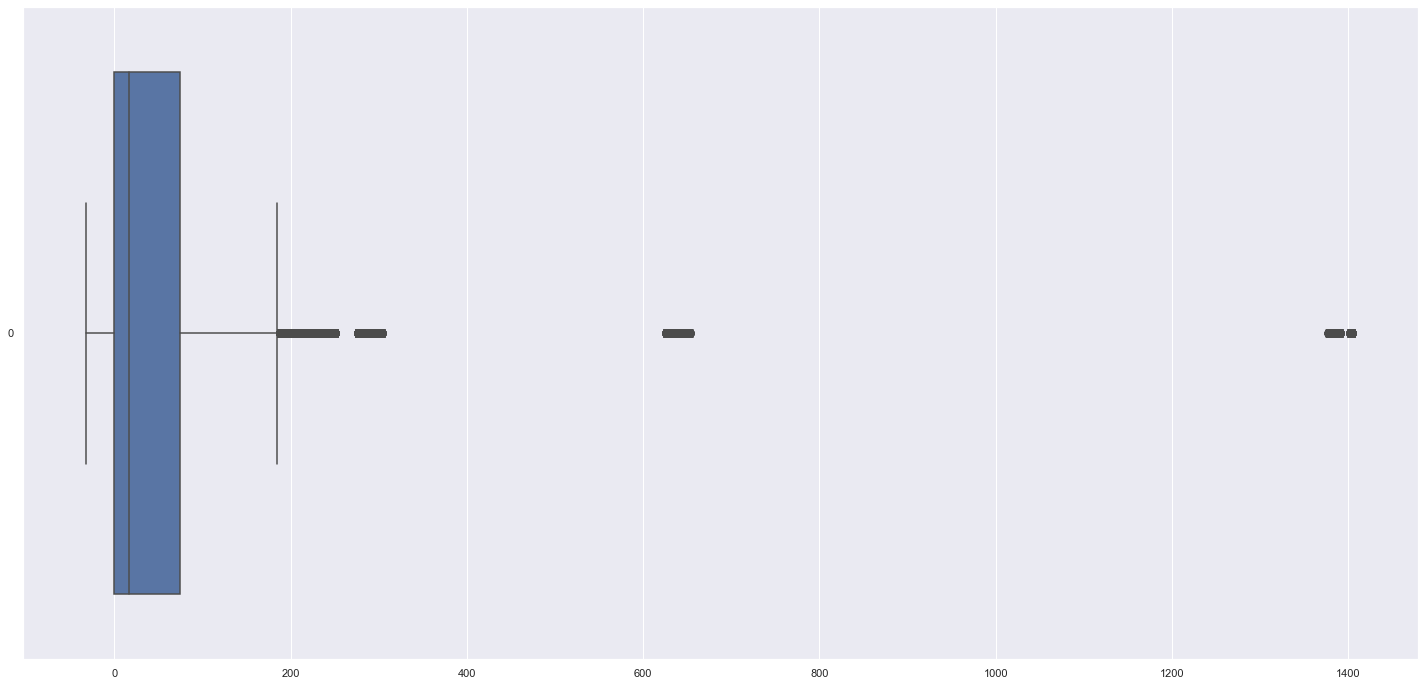

In [15]:
sns.boxplot(data= df5['competition_time_month'], orient='h' ); #tem muitos outliers -> Robust Scaler

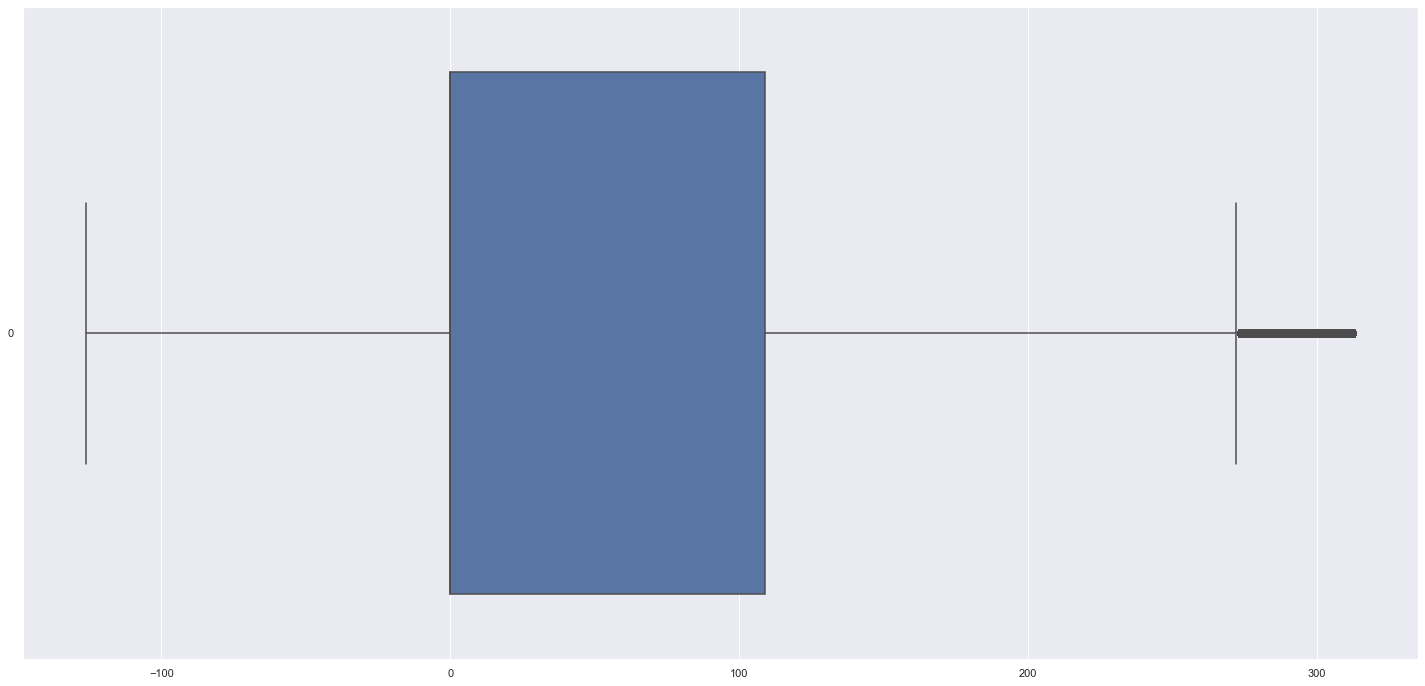

In [16]:
sns.boxplot( data= df5['promo2_time_week'], orient='h'); #tem menos outliers, mas vamos de Robust Scaler

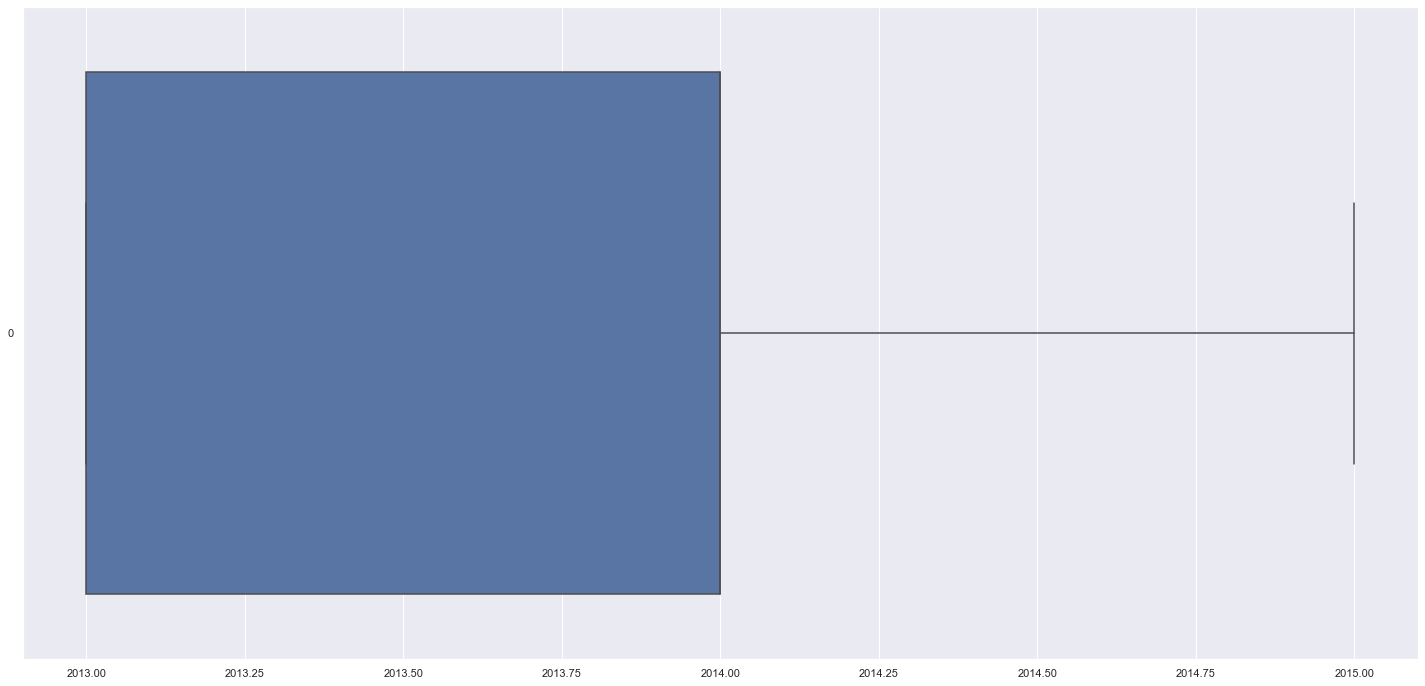

In [17]:
sns.boxplot( data= df5['year'], orient='h' ); #sem outliers -> Min Max Scaller

In [21]:
#instancia Robust Scaller e Min Max Scaller:
rs = RobustScaler()
mms = MinMaxScaler()

#função fit_transform encontra os quartis 1 e 3 da coluna e aplica a formula. 
#Vamos aplicar nas variáveis:

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values ) 
#salvar para uso na API, wb= escrita
pickle.dump (rs, open ('../parameter/competition_distance_scaler.pkl', 'wb') )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values ) 
pickle.dump (rs, open ('../parameter/competition_time_month_scaler.pkl', 'wb') )

#promo2_time_week
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values ) 
pickle.dump (rs, open ('../parameter/promo2_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform(df5[['year']].values ) 
pickle.dump (mms, open ('../parameter/year_scaler.pkl', 'wb') )

Vamos observar agora as 4 variáveis reescaladas:

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


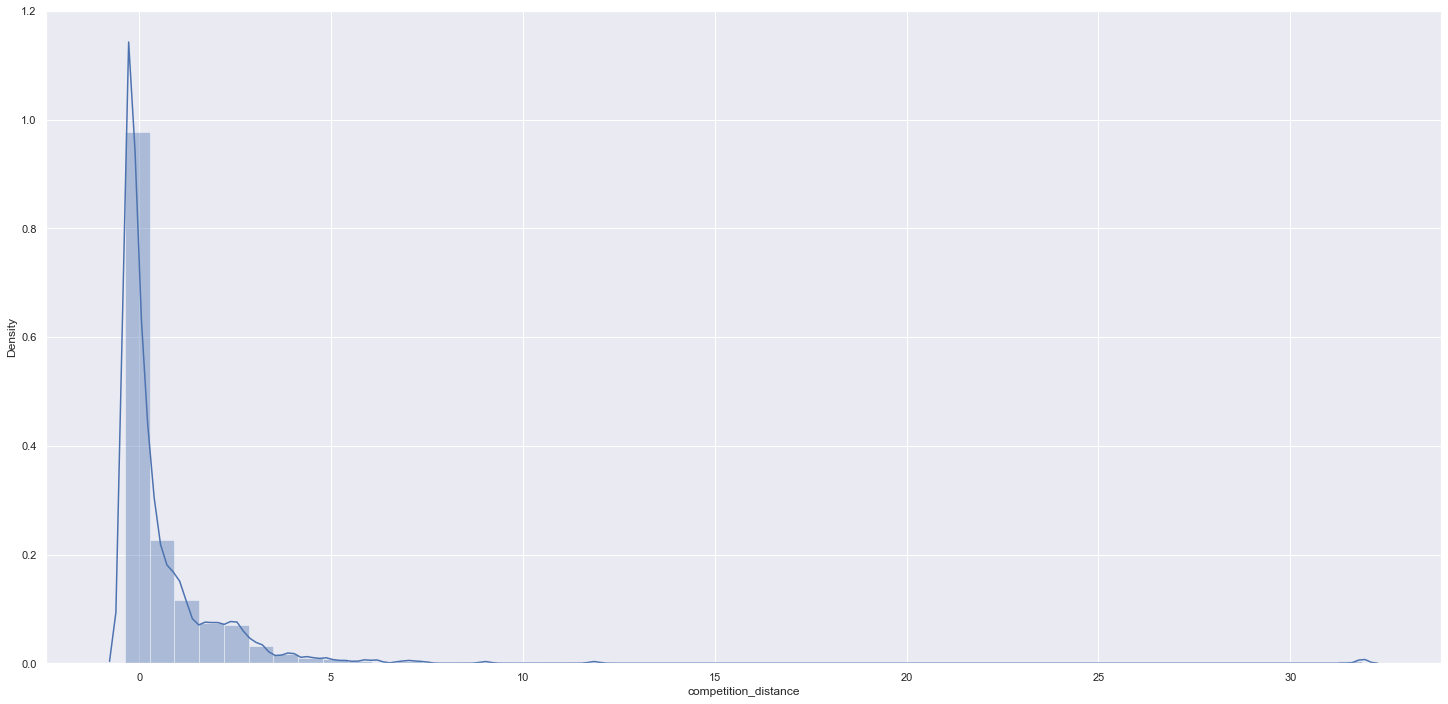

In [22]:
sns.distplot( df5['competition_distance'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


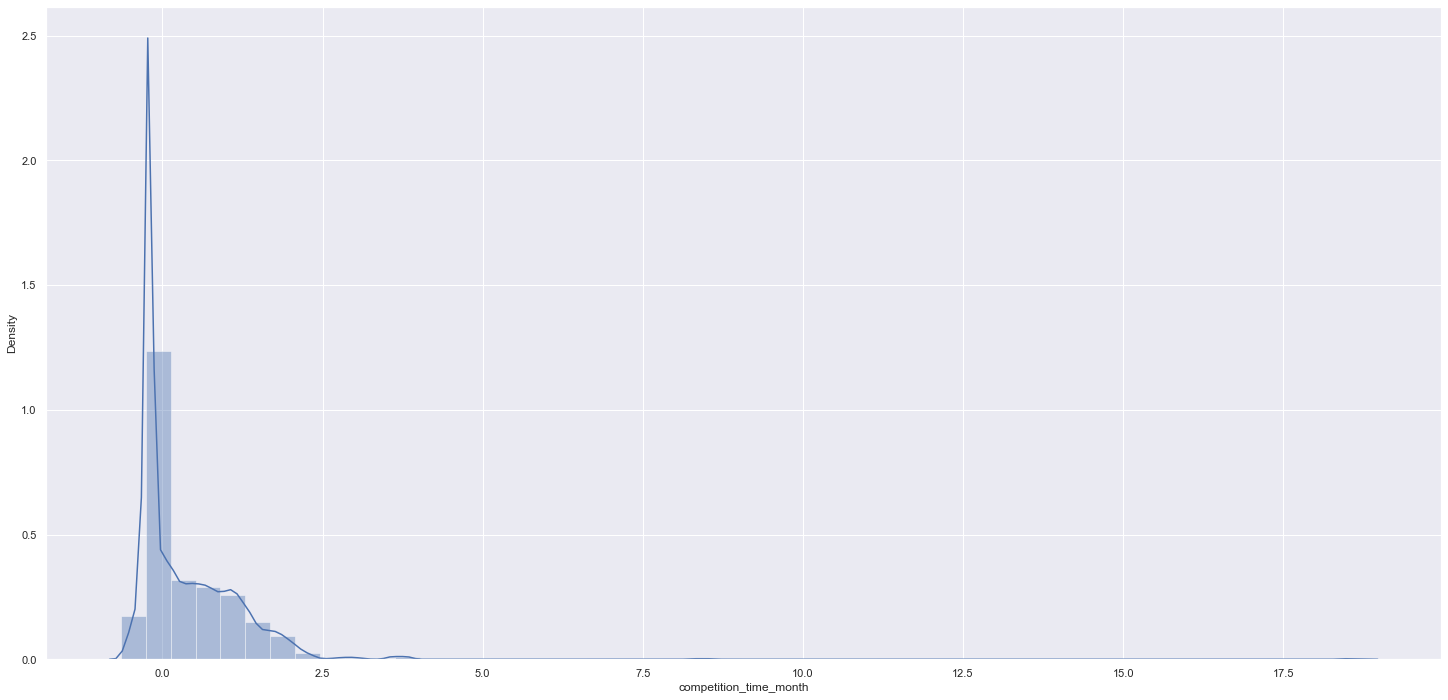

In [23]:
sns.distplot( df5['competition_time_month'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


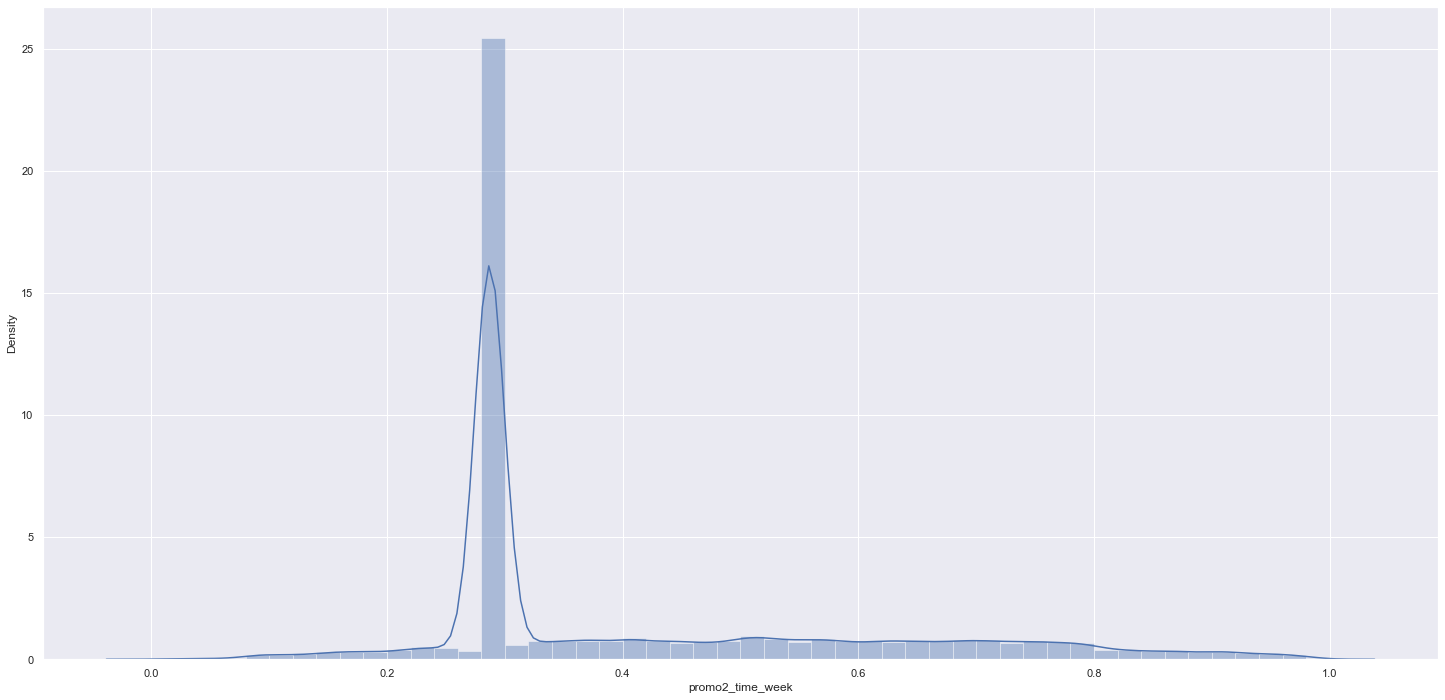

In [24]:
sns.distplot( df5['promo2_time_week'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


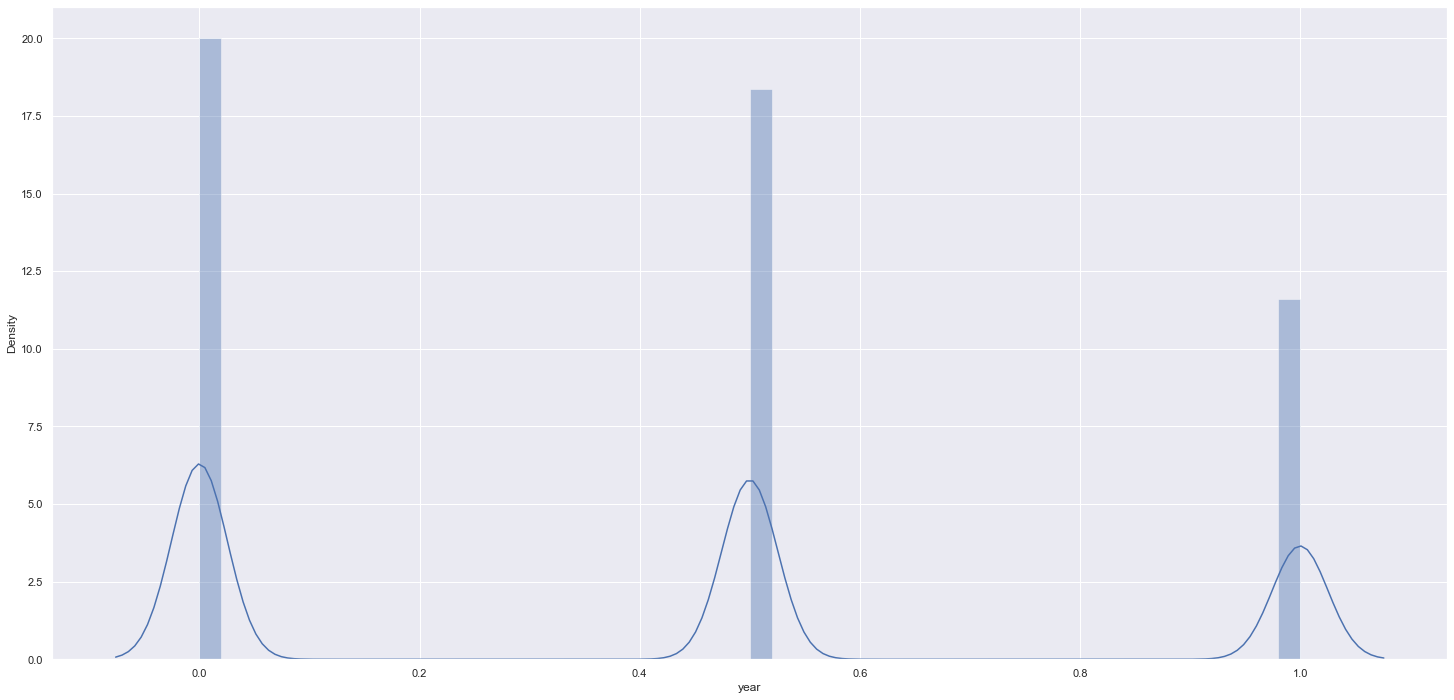

In [25]:
sns.distplot( df5['year'] );

## Transformação

### Encoding

Vamos aplicar o encoding nas variáveis categóricas. Vamos listar elas abaixo:

In [37]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [ ]:
#variáveis categóricas:

#state_holiday = feriado nacional (a = public holiday, b = Easter holiday, c = Christmas, 0 = Dia Comum)
#store_type = indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)
#assortment = indica o nível de sortimento da loja: (a = basic, b = extra, c = extended)

#### state_holiday - (One-Hot-Encoding)

state_holiday: é um estado, estou num estado de natal, depois vou pra estado de dias normais.
Vou usar one hot encoding aqui.

In [38]:
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [39]:
#vai criar as 4 colunas novas das possíveis variações agora:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,c,basic,-0.170968,9,2008,0,31,...,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,a,basic,-0.283871,11,2007,1,13,...,Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,a,basic,1.903226,12,2006,1,14,...,Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,c,extended,-0.275806,9,2009,0,31,...,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,a,basic,4.448387,4,2015,0,31,...,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### store_type (Label Encoding)

store_type: vamos usar label encoding, porque não há ordem explícita nas categorias a, b e c.

In [41]:
#instanciar
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#exportar para uso na API
pickle.dump( le, open( '../parameter/store_type_scaler.pkl', 'wb' ) )

In [42]:
#vai ter trocado aleatoriamente as letras por números, e atribuí na mesma coluna:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,basic,-0.170968,9,2008,0,31,...,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,0,basic,-0.283871,11,2007,1,13,...,Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,0,basic,1.903226,12,2006,1,14,...,Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2,extended,-0.275806,9,2009,0,31,...,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,0,basic,4.448387,4,2015,0,31,...,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### assortment (Ordinal Encoding)

assortment tem uma ordem: basic, extra, extended, vamos manter esta ordem então, e usar Ordinal Encoding

In [43]:
#explicitar a ordem em dict:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [44]:
#vai ter substituído pela escala
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,-0.170968,9,2008,0,31,...,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,1,0,1,-0.283871,11,2007,1,13,...,Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,1,0,1,1.903226,12,2006,1,14,...,Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,-0.275806,9,2009,0,31,...,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,0,1,4.448387,4,2015,0,31,...,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Nada impede fazer o target encoding pra todas, por exemplo. No primiero ciclo do Crisp, faz pelo feeling, e melhora mais tarde, pra não perder muito tempo aqui e colocar rodar logo.

### Response Variable Transformation

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


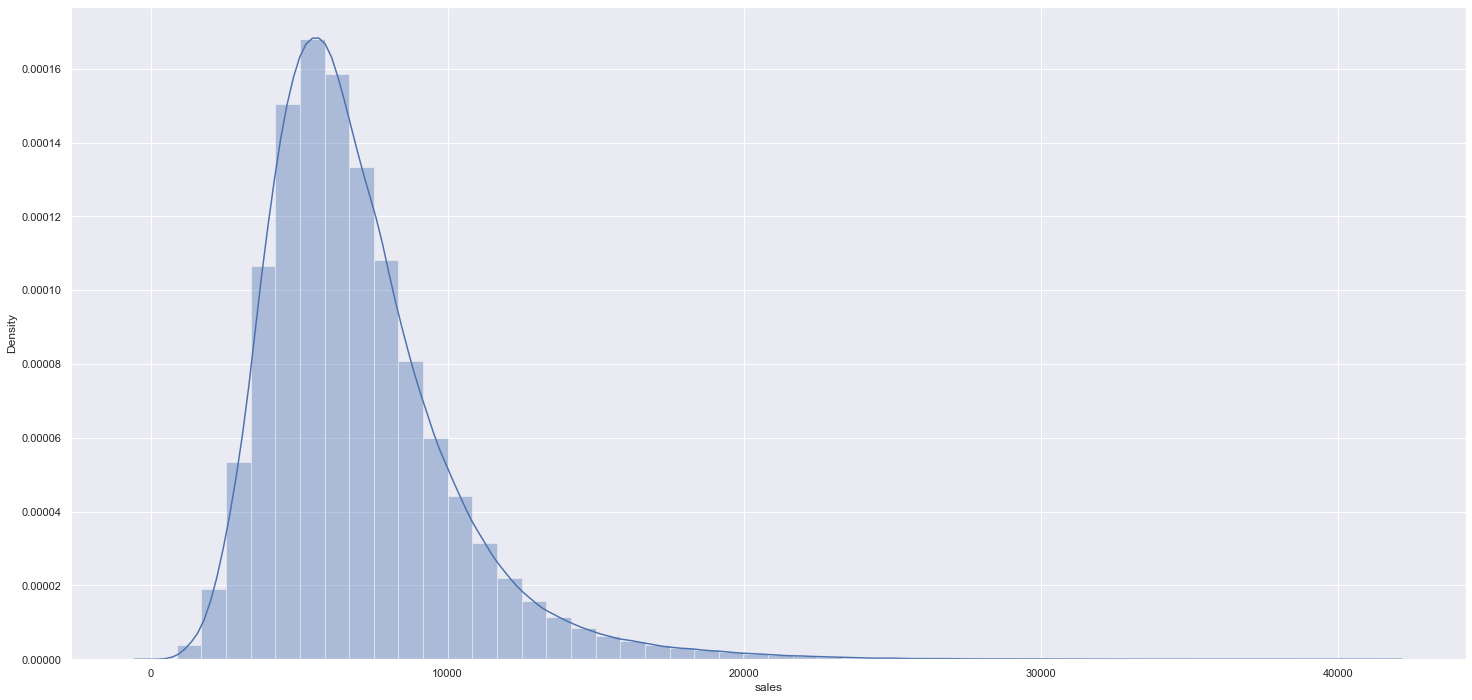

In [45]:
#Notamos que sales atualmente tem uma skew positiva leve:
sns.distplot( df5['sales'] );

In [46]:
#vamos normalizar com Transformação Logarítmica:
df5['sales'] = np.log1p (df5['sales'] )

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


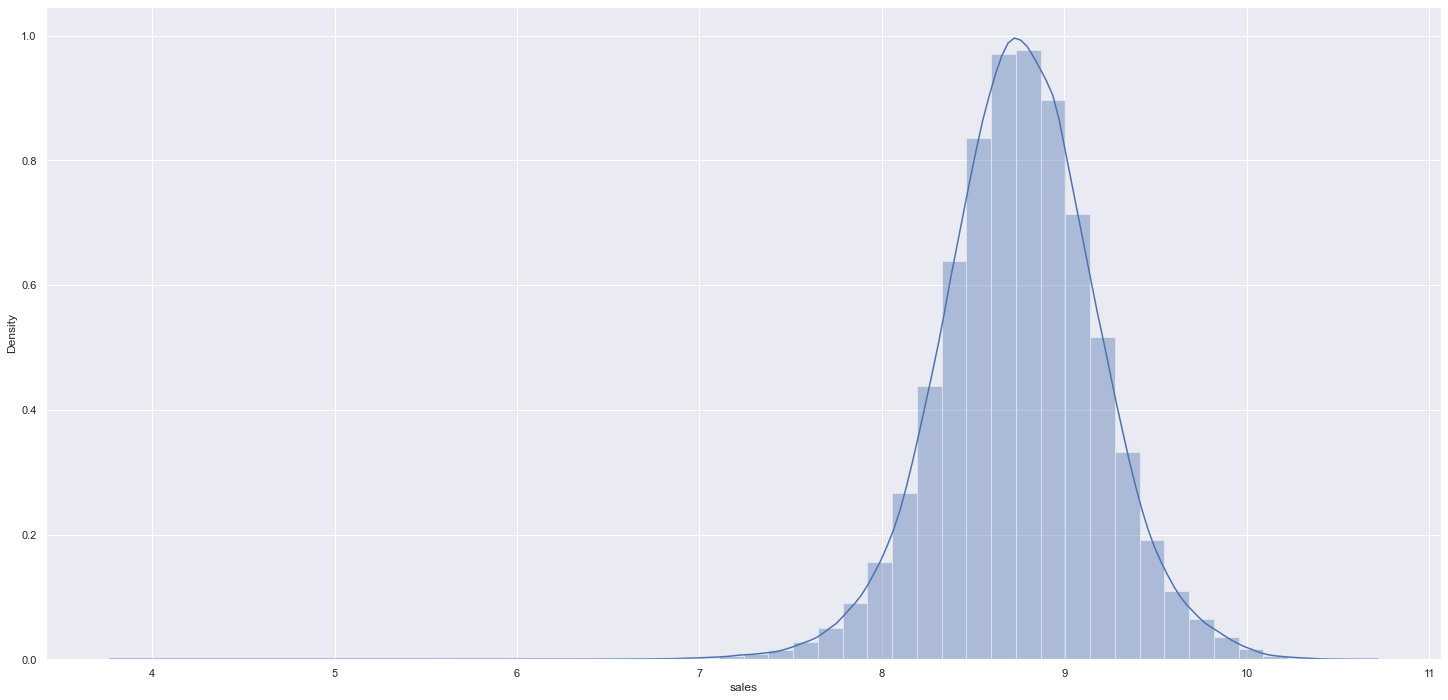

In [47]:
#resultado: distribuição mais pra direita, normalizada
sns.distplot( df5['sales'] );

### Nature Transformation

In [48]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,...,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,...,Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,...,Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,...,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,...,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [ ]:
#Variáveis de natureza ciclica: 

#month - mês extraído da data do registro
#day - dia extraído da data do registro
#day_of_week - dia da semana extraído da data do registro
#week_of_year - semana do ano extraído da data do registro

#Obs: year não é cíclico, pois nunca se repete, já foi tratado anteriormente.

In [49]:
#month
df5['month_sin'] = df5['month'].apply (lambda x: np.sin(x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply (lambda x: np.cos(x * ( 2. * np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply (lambda x: np.sin(x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply (lambda x: np.cos(x * ( 2. * np.pi/30 ) ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin(x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos(x * ( 2. * np.pi/7 ) ) )

In [50]:
df5.sample(5)

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
223633,423,2,2014-11-25,9.339964,1692,1,1,0,1,1,-0.170968,5,2014,0,48,...,-0.135135,2014-11-24,0.287016,0,0,0,1,-5.000000e-01,8.660254e-01,-8.660254e-01,0.500000,-0.464723,0.885456,0.974928,-0.222521
207926,715,1,2014-12-15,9.585827,1132,1,1,0,0,1,2.012903,6,2014,0,51,...,-0.135135,2014-12-15,0.287016,0,0,0,1,-2.449294e-16,1.000000e+00,1.224647e-16,-1.000000,-0.120537,0.992709,0.781831,0.623490
787531,967,6,2013-03-02,9.026297,825,1,0,0,0,3,0.198387,9,2013,1,36,...,-0.310811,2013-09-02,0.225513,0,0,0,1,1.000000e+00,6.123234e-17,4.067366e-01,0.913545,0.885456,0.464723,-0.781831,0.623490
812612,489,1,2013-02-04,9.208639,784,1,1,1,0,1,2.037097,11,2013,1,37,...,-0.337838,2009-09-07,0.692483,0,0,0,1,8.660254e-01,5.000000e-01,7.431448e-01,0.669131,0.663123,0.748511,0.781831,0.623490
456836,334,6,2014-02-22,8.470311,540,1,0,0,3,3,0.275806,8,2008,1,18,...,0.689189,2013-04-29,0.382688,0,0,0,1,8.660254e-01,5.000000e-01,-9.945219e-01,-0.104528,0.822984,0.568065,-0.781831,0.623490


In [51]:
df5.shape #ok!

(844338, 40)

In [52]:
#Save CSV:
df5.to_csv('../data/5_data_preparation_done.csv', index=False)
#no import needed, no message will appear.

# Passo 06 - Feature Selection

## Checkpoint [2]

É possível retormar o projeto a partir daqui.

In [73]:
                                                    # lê todo o arquivo de uma vez 
df6 = pd.read_csv("../data/5_data_preparation_done.csv", low_memory=False)

In [74]:
df6.shape

(844338, 40)

Diferenças entre seguir com as variáveis da memória, e importar:
Memória:
state_holiday_christmas                  uint8
state_holiday_easter_holiday             uint8
state_holiday_public_holiday             uint8
state_holiday_regular_day                uint8
date                            datetime64[ns]

Importar:
date                             object
state_holiday_christmas           int64
state_holiday_easter_holiday      int64
state_holiday_public_holiday      int64
state_holiday_regular_day         int64

uint8 vem do numpy. 
Vou apenas converter date para datetime, e seguir.    

In [75]:
df6['date'] = pd.to_datetime( df6['date'] )

In [76]:
df6.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
customers                                int64
open                                     int64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                   float64
month                                    int64
day          

In [78]:
#remover variáveis que foram usadas pra criar outras e não são mais necessárias (9):
cols_drop = ['week_of_year','day','month','day_of_week','promo2_since', 
             'promo_interval', 'competition_since', 'year_week', 'month_map' ]

#date e sales tem que deletar também, mas vamos usar pra uns cálculos, então faremos depois
df6 = df6.drop( cols_drop, axis=1) 

In [80]:
df6.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [81]:
df6.shape

(844338, 31)

## Split dataframe into training and test dataset

- Dados de treino: parte do dataset usada pra trainar o modelo.
- Dados de teste: parte do dataset usado pra medir a acurácia.
    Dado de teste é para simular dado de produção, e não temos a variável resposta nele.

Sendo um problema de time series, vou pegar as últimas 6 semanas de venda (as mais importantes, pois são mais próximas da data atual e devem refletir a realidade ao máximo), e separar isto para teste.

Todas as vendas antes disso, serão treino.

In [83]:
#pegar data mínima (inicial) de venda de cada loja:
df6[['store', 'date']].groupby( 'store' ).min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [84]:
#pegar data máxima (final) de venda de cada loja:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [88]:
#pegar 60 dias antes da última data
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - dt.timedelta( days=6*7 ) 

Timestamp('2015-06-19 00:00:00')

In [89]:
#Dinâmica:
# X = dataset todo
# Y = var resposta

#training dataset:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset:
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

#Conferência das data (ok)
print ('Traning Min Date: ',X_train['date'].min() )
print ('Traning Max Date: ', X_train['date'].max() )

print ('\nTest Min Date: ', X_test['date'].min() )
print ('Test Max Date: ', X_test['date'].max() )

Traning Min Date:  2013-01-01 00:00:00
Traning Max Date:  2015-06-18 00:00:00

Test Min Date:  2015-06-19 00:00:00
Test Max Date:  2015-07-31 00:00:00


In [90]:
#whole dataset - training
X_train.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
41396,1,2015-06-18,8.443762,498,1,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41397,2,2015-06-18,8.547722,594,1,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41398,3,2015-06-18,8.927712,743,1,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41399,4,2015-06-18,9.091669,1138,1,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41400,5,2015-06-18,8.502080,545,1,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [92]:
X_train.shape

(802942, 31)

In [91]:
#whole dataset - test
X_test.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [93]:
X_test.shape

(41396, 31)

In [95]:
#response var (já normalizada) - training
y_train.head()

41396    8.443762
41397    8.547722
41398    8.927712
41399    9.091669
41400    8.502080
Name: sales, dtype: float64

In [96]:
y_train.shape

(802942,)

In [94]:
#response var (já normalizada) - test 
y_test.head()

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

In [97]:
y_test.shape

(41396,)

## Boruta as Feature Selector (Seleção por Subset - Wrapper Methods)

In [99]:
X_train.head()

,store,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
41396,1,2015-06-18,8.443762,498,1,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41397,2,2015-06-18,8.547722,594,1,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41398,3,2015-06-18,8.927712,743,1,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41399,4,2015-06-18,9.091669,1138,1,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
41400,5,2015-06-18,8.502080,545,1,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [103]:
#training and test dataset for Boruta

    #.values pra pegar só os valores, sem o header, deletamos date e sales por serem dados de treino
X_train_n = X_train.drop( ['date','sales'],axis=1 ).values
    #ravel pra colocar num vetor contínuo todos os valores de sales contidos em Y_train
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
    #n_jobs=-1 pra usar todos cores da máquina, usando paralelismo
rf = RandomForestRegressor( n_jobs=-1 )

#define Boruta
    #instancia, usando Randon Forest, n_estimators é o número de galhos, 
    # verbose=2 pra ver o log, pois demora um pouco, random_state=42 pra partir do mesmo início
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


Log do Boruta:

- Iteration: número de iterações até o Boruta decidir as features
- Confirmed: features relevantes pro modelo
- Tentative: teve dúvida, nesta iteração não conseguiu classificar
- Rejected: variáveis já rejeitadas como relevantes

### Best features from Boruta

In [104]:
#retorna True ou False pra cada coluna
cols_selected = boruta.support_.tolist()

#obter lista das features selecionadas a partir de cols_selected (True e False pra cada coluna)
X_train_fs = X_train.drop( ['date','sales'],axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

#obter lista das features não selecionadas
cols_not_selected_boruta = list (np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## Manual Feature Selection

In [105]:
cols_selected_boruta

Index(['store', 'customers', 'promo', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month', 'promo2_time_week',
       'month_cos', 'day_cos', 'week_of_year_cos', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')

In [106]:
cols_not_selected_boruta

['day_sin',
 'is_promo',
 'month_sin',
 'open',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

Agora tenho as variáveis que o Boruta considerou relevantes.

Tenho também as que eu, como DS, considerei ALTA relevância lá na EDA. 
A EDA é relevante pra questionar a avaliação dos algoritmos com meu feeling.

Vou fazer um merge das duas.

Minha análise:

H9:
- sobre o 'year', Boruta descartou, mas eu vi que é relevante. Sendo a primeira iteração, vou mabter fora, e no 2º ciclo adiciono se necessário

H10
- sobre o 'month', Boruta considerou só o 'month_cos' como relevante. Vamos colocar 'month_sin' também.

H11
- sobre o 'day', Boruta considerou só 'day_cos', Vamos colocar 'day_sin' também.

Outras:
- 'week_of_year_sin' também será considerada relevante por mim, apesar do Boruta não considerar.
- 'customers' também foi selecionado, mas como não temos como prever, nem vai ser mais considerada daqui para adiante. 

Salvar agora o resultado do boruta, incluindo as considerações acima, para não precisar rodar novamente:

In [109]:
cols_not_selected_boruta = [
    'is_promo',
    'open',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year'
]

In [110]:
cols_selected_boruta = [
    'store', 
    'promo', 
    'store_type', 
    'assortment',
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2', 
    'promo2_since_week',
    'promo2_since_year', 
    'competition_time_month', 
    'promo2_time_week',
    'month_cos',
    'month_sin',#added manually by me, was not sel. by Boruta
    'day_cos',
    'day_sin',#added manually by me, was not sel. by Boruta
    'week_of_year_cos', 
    'week_of_year_sin',#added manually by me, was not sel. by Boruta
    'day_of_week_sin',
    'day_of_week_cos']

# incluir de volta o date (vamos usar pra separar o dataset mais pra frente) 
# e o sales (é nossa var resposta, vamos precisar dela pra treinar o algoritmo)

#columns to add
feat_to_add = ['date', 'sales']

#final features 
#cria cols_selected_boruta_full, que contém 'date' e 'sales', pra manter cols_selected_boruta sem eles.
cols_selected_boruta_full = cols_selected_boruta.copy()
    #extend adiciona uma lista na outra
cols_selected_boruta_full.extend (feat_to_add)

In [111]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [112]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

In [113]:
#Save CSV:
df6.to_csv('../data/6_feature_selection.csv', index=False)
#no import needed, no message will appear.

# Passo 07 - Machine Learning Modelling

## Criação Treino e Teste à partir do Boruta 

In [114]:
X_train[ cols_selected_boruta_full ].head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


In [115]:
X_test[ cols_selected_boruta_full ].head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.568646
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.710290
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,9.025816
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,9.546527
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8.481151


In [117]:
#conferência:
print ('Data inicial Treino: ', X_train[ cols_selected_boruta_full ]['date'].min() )
print ('Data final Treino: ', X_train[ cols_selected_boruta_full  ]['date'].max() )

print ('\nData inicial Teste: ', X_test[ cols_selected_boruta_full  ]['date'].min() )
print ('Data final Teste: ', X_test[ cols_selected_boruta_full  ]['date'].max() )

Data inicial Treino:  2013-01-01 00:00:00
Data final Treino:  2015-06-18 00:00:00

Data inicial Teste:  2015-06-19 00:00:00
Data final Teste:  2015-07-31 00:00:00


Criar vars treino e teste só com o que o Boruta Selecionou: 

Peguei cols_selected_boruta e não cols_selected_boruta_full, pra não pegar 'date' e 'sales', que não são usados pra treinar o modelo.

In [118]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [119]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [120]:
x_test.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521


Agora, vamos testar 5 modelos:

## Average Model

É a média de vendas de cada uma das lojas.
Média é um modelo linear (para dados com comportamento mais simples)

Criar função para cálculo do erro:

In [499]:
# ml_error( model_name, y, yhat ) -> transportada para o Helper Funcions 

Calcular o erro do modelo de Média:

In [126]:
#actual sales -------------------------------------------------------------------
#Já temos Y_test (ok)

#prediction sales ------------------------------------------------------------------
#Cria aux1, a partir dos dados de teste: DS sem vendas (em x_test) e Vendas (em Y_test)
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() #Y_test: (loja|venda)
    #agora tenho o ds original em aux1, só com dados de teste

#---- Como estamos modelando a média, vamos obter o valor médio de vendas por loja dos dados de teste
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
    #temos agora em aux2 todas as predições (médias de venda por loja do dataset teste)
#agora, precisamos anexar de volta:
aux1 = pd.merge(aux1, aux2, how='left', on='store')
#y~ na matemática é tudo o que é estimado. 
# Chamo agora de 'predictions' as vendas previstas (a partir da média simples) do DS de teste por loja
yhat_baseline = aux1['predictions'] 
    
#performance ---------------------------------------------------------------------
    #passo nome do modelo, y_test sendo as vendas reais e yhat_baseline sendo as predições de vendas por loja pela média
    #Lá em cima na Transf. da Var Resposta, fizemos o log de vendas. O oposto do log é o exponencial.
        #Vamos usar np.expm1 agora então pra voltar pros valores originais aplicando o exponencial.
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline)  )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [127]:
yhat_baseline.head()

0    8.373392
1    8.460676
2    8.795885
3    9.194715
4    8.346624
Name: predictions, dtype: float64

## Linear Regression Model

In [129]:
#treina o modelo
    #.fit() treina o modelo com dados de treino (y_train = vendas, x_train = demais vars)
lr = LinearRegression().fit( x_train, y_train)

#extrai previsão do modelo
    #predict() faz a previsão com dados de teste (apenas x_test, sem vendas)
yhat_lr = lr.predict ( x_test )

#calcula performance
    #passa vendas reais de teste (y_test), vs as predições do modelo (yhat_lr):
lr_result = ml_error ( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Análise do ERRO RMSE:
O Erro RMSE do modelo de regressão linear é muito maior que o erro do modelo de média.
Logo:
1 - o modelo de média é melhor que a regressão linear aqui
2 - isto nos diz que os dados tem comportamento complexo (não linear), e muito provavelmente modelos não lineares não vão conseguir aprender este comportamento.
Vamos implementar o Regularized só pra ter o modelo implementado.

### Linear Regression Model - Cross Validation

In [159]:
lr_result_cv = cross_validation( x_training, 5 , "Linear Regression", lr, verbose=False )
lr_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37


Notamos que ao fazer só com um pedaço do dataset antes (lr_result), o RMSE foi de 2671.
Agora, ao fazer com mais partes através da fução cross_validation, o RMSE foi de 2952. 
Haviamos pego então um pedaço "bom" pra fazer a predição, e o erro antes deu menor.
Por isso do cross validation, passar por mais pedaços do dataset, pra pegar uma maior variabilidade.

## Linear Regression Regularized Model - Lasso

In [131]:
#training
    #alfa - fator multiplicador dos pesos, pra ficarem dentro do range desejável
lrr = Lasso (alpha=0.01).fit( x_train, y_train)

#prediction
yhat_lrr = lrr.predict ( x_test )

#performance
lrr_result = ml_error ( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


Comparando o RMSE, também notamos que o erro é bem maior que o RMSE do modelo da média.

Vamos agora implementar dois modelos não-lineares (para dados com comportamento mais complexo)

### Lasso - Cross Validation

In [160]:
lrr_result_cv = cross_validation( x_training, 5 , "Lasso", lrr, verbose=False )
lrr_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26


Análise: o lrr_result quando rodado sobre a última semana de vendas, deu RMSE de 2744
Notamos que foi uma semana um pouco melhor que se comparado a média das 5 passadas no k-fold, pois o RMSE médio agora de lrr_result_cv foi de 3057, tendo performance um pouco pior considerando todo o dataset.

## Random Forest Regressor

In [133]:
#model
    #n_estimators=100 -> quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
    #n_jobs=-1 -> usar todas as threads
    #random_state=42 -> partir da mesma origem aleatória (pode ser qualquer número)
rf = RandomForestRegressor (n_estimators=20, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

#prediction
yhat_rf = rf.predict ( x_test )

#performance
rf_result = ml_error ( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,691.959253,0.101707,1029.851202


### Random Forest Regressor - Cross Validation

In [161]:
#ideal é usar os 5 kfolds (±40 min). Usei 2 pra agilizar, visto que já rodei antes, e vamos seguir com xgboost:
rf_result_cv = cross_validation( x_training, 2 , "Random Forest Regressor", rf, verbose=True )
rf_result_cv


KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:00
kFold validation end date:  2015-06-18 00:00:00


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,793.64 ± 75.36,0.11 ± 0.01,1180.16 ± 148.53


## XGBoost Regressor

In [136]:
    #random_state=42 -> partir da mesma origem aleatória (pode ser qualquer número)
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', #função objetiva
                             n_estimators=20, #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
                             eta=0.01, #quantas passadas usa pra fazer o aprendizado
                             max_depth=10, #máxima ramificação da árvore
                             subsample=0.7, #% das variáveis de amostra pra selecionar as relevantes
                             colsample_bytree=0.9 ).fit( x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict ( x_test )

#performance
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,4609.537213,0.622142,5336.650601


Neste momento, não estamos tão preocupados em encontrar o melhor parâmetro. Vamos fazer isso no fine tuning.
Meigarom implementa estes 5 modelos com parâmetros default. O que performar melhor, ele utiliza e coloca em produção logo pra ganhar velocidade (desde que o tipo de problema que o algoritmo resolve seja o que ele tem pra resolver)
Até porque fine tuning não dá salto de 70 pra 80% na acurária. O que dá este salto, são as variáveis utilizadas.

### XGBoost Regressor - Cross Validation

In [163]:
#ideal é usar os 5 kfolds. Usei 2 pra agilizar, visto que já rodei antes, e vamos seguir de fato com o xgboost:
xgb_result_cv = cross_validation( x_training, 2 , "XGBoost Regressor", model_xgb, verbose=True )
xgb_result_cv


KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:00
kFold validation end date:  2015-06-18 00:00:00


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,5021.99 ± 99.01,0.64 ± 0.0,5763.36 ± 151.88


## Compare Model's Performance

### Single Performance

In [137]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro:
modelling_result= pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values( 'RMSE' ) #Ordenar pelo modelo com o menor erro

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,691.959253,0.101707,1029.851202
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735
0,XGBoost Regressor,4609.537213,0.622142,5336.650601


PS: Nos resultados do Meigarom, tivemos menor erro em Randos Forest e depois XGBoost (modelos não lineares).
    Usei também só 20 'n_estimators', pois aumenta muito o tempo de execução, mas também aumenta a performance. 

Sendo assim, o problema que estamos resolvendo de previsão de vendas é um problema complexo, logo modelos lineares não funcionam bem pra isto. Vamos resolver com os modelos não lineares.

Olhando apenas o RMSE, usaríamos Random Forest, mas ocorre que pegamos apenas as 6 últimas semanas para teste. Pode acontecer de termos um comportamento esperado nestas semanas, e isto não refletir a realidade.. não generalizar bem.

Por isso, temos o Cross-Validation: cortar várias fatias do dataset, e medir a performance do modelo nestas diferentes partes.
Esta média então será nossa performance real.

### Real Performance - Cross Validation

In [164]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro: 
    #(3º vez que rodei, com menos 2 k_folds só para rf e xgb. ps: xgb na versão 0.9 agora, não mais 1.5.1)
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37
0,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26
0,Random Forest Regressor,793.64 ± 75.36,0.11 ± 0.01,1180.16 ± 148.53
0,XGBoost Regressor,5021.99 ± 99.01,0.64 ± 0.0,5763.36 ± 151.88


In [157]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro: 
    #(2º vez que rodei, com menos k_folds e configs n_estimators menor)
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 ± 231.33,0.19 ± 0.01,3536.63 ± 703.2
0,Lasso,1516.15 ± 257.71,0.19 ± 0.01,3541.76 ± 732.89
0,Random Forest Regressor,404.76 ± 38.22,0.05 ± 0.0,600.14 ± 85.27
0,XGBoost Regressor,7419.08 ± 128.28,1.0 ± 0.0,8073.2 ± 175.36


In [671]:
#agrupar todos os resultados dos modelos pra ver qual o de menor erro: (1ª vez que rodei)
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 ± 231.33,0.19 ± 0.01,3536.63 ± 703.2
0,Lasso,1516.15 ± 257.71,0.19 ± 0.01,3541.76 ± 732.89
0,Random Forest Regressor,405.43 ± 97.89,0.05 ± 0.01,591.94 ± 145.44
0,XGBoost Regressor,7044.41 ± 588.03,0.95 ± 0.0,7696.95 ± 687.75


Notamos que de longe, a Random Forest trouxe um resultado muito superior que os demais modelos.
Random Forest é um algoritmos bem legal pra regressão e classificação, rápido pra treinar, vale se aprofundar nele.
Neste projeto, vamos implementar a XGBoost porque tem menos material disponível sobre.
Meigarom implementou recentemente uma XGBoost também, que performou pouco menos que uma Random Forest, mas veio de 26BG pra 300mb de tamanho com a mudança. Empresa dispensou a máquina de 32 GB então que hospedava, economizando, e a acurácia perdida foi pequena, compensando a economia de server.

## Implementando Time-Series Cross-Validation

Precioso agora a partir dos dados de treino, separar os dados de validação. (os de teste nem entram aqui, já foram separados antes).

In [138]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969


In [139]:
x_training = X_train[ cols_selected_boruta_full ]

In [140]:
#agora sim temos todas as variáveis, com date e sales no final
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
41396,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
41397,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
41398,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
41399,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
41400,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


In [141]:
x_training['date'].min()

Timestamp('2013-01-01 00:00:00')

In [142]:
x_training['date'].max()

Timestamp('2015-06-18 00:00:00')

Os dados de treino variam entre 2013-01-01 e 2015-06-18.

Agora vou obter as datas do validação, sendo as últimas 6 semanas que estão no training:

In [143]:
#start and end date for validation (last 6 weeks)
validation_start_date = x_training['date'].max() - dt.timedelta( days=1*6*7 ) 
        #Timestamp('2015-05-07 00:00:00')

    #o timedelta abaixo poderia ser removido nesta primeira iteração, mas é útil nas próximas
validation_end_date = x_training['date'].max() - dt.timedelta( days=0*6*7 )
        #Timestamp('2015-06-18 00:00:00')

In [ ]:
Agora, vamos criar dados de treino e validation:

In [144]:
#filtering dataset
    #seto em training dados anteriores ao validation_start_date (2015-05-07)
training = x_training[x_training['date'] < validation_start_date ]
    #seto em validation o start e end já calculados, sendo as últimas 6 semanas:
validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date) ]

In [147]:
training['date'].min() #Timestamp('2013-01-01 00:00:00')
training['date'].max() #Timestamp('2015-05-06 00:00:00')

Timestamp('2015-05-06 00:00:00')

In [149]:
validation['date'].min() #Timestamp('2015-05-07 00:00:00')
validation['date'].max() #Timestamp('2015-06-18 00:00:00')

Timestamp('2015-06-18 00:00:00')

Agora, incremento 1 após o days pra criar os dados da próxima iteração:

In [150]:
validation_start_date2 = x_training['date'].max() - dt.timedelta( days=2*6*7 ) 
validation_end_date2 = x_training['date'].max() - dt.timedelta( days=1*6*7 )
    
training2 = x_training[x_training['date'] < validation_start_date2 ]
validation2 = x_training[ (x_training['date'] >= validation_start_date2) & ( x_training['date'] <= validation_end_date2) ]

In [151]:
training2['date'].min()

Timestamp('2013-01-01 00:00:00')

In [152]:
training2['date'].max()

Timestamp('2015-03-25 00:00:00')

In [153]:
validation2['date'].min()

Timestamp('2015-03-26 00:00:00')

In [154]:
validation2['date'].max()

Timestamp('2015-05-07 00:00:00')

Acima, notamos então que na primeira iteração
Treino: 2013-01-01 -> 2015-05-06 | Validação: 2015-05-07 -> 2015-06-18 (6 semanas)

Na segunda iteração:
Treino: 2013-01-01 -> 2015-03-25 (6 semanas menos que antes) | Validação:  2015-03-26 -> 2015-05-07 (6 semanas)

Está fazendo portanto ao contrário da imagem do Time Series Cross validation abaixo. No laço for, vou inverter isto abaixo com reversed, pra ficar igual a imagem.

Pra automatizar esse processo acima e fazer o cross validation, vamos usar uma variável k-fold (para cada separação) mais abaixo.

Dentro da função abaixo, descobrimos o erro de cada um dos folds (separações dos dados).
Já calculcamos a média e desvio padrão dos kfolds, pra termos a performance real do modelo!

Na prática, meia dúzia de k-folds em séries temporais é suficiente. Não seria só mais demorado pegar todas as partes do dataset conforme a imagem abaixo (precisaria uns 15, 20 kfolds..), como é interessantes darmos mais valor aos dados mais recentes, por estarem mais próximos do presente.

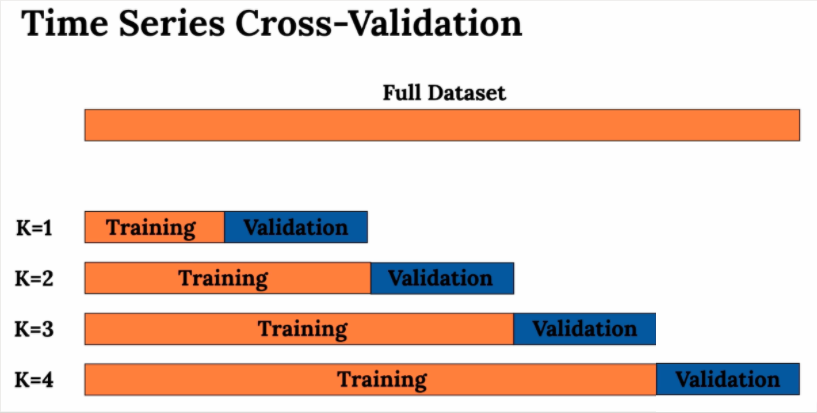

In [155]:
Image ('../img/time_series_cross_validation.png')

In [506]:
#cross_validation( x_training, kfold , model_name, model, verbose=False) -> transportada para o Helper Functions

Testando a função cross_validation para uma Linear Regression:

In [157]:
model = LinearRegression()
#model = Lasso( alpha=0.01 )
#model = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42 )
#model = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, subsample=0.7, colsample_bytee=0.9 )

a = cross_validation( x_training, 5, 'Linear Regression', model, True)


KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:0

Dataframe já com o resultado real de performance (erro) e desvio padrão:

In [158]:
a

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37


Agora, voltamos em cada modelo e complementamos a avaliação de performance, chamando a função de cross validation que retorna a performance real.

# Passo 08 - Hyperparameter Fine Tuning

Vamos seguir de Random Search, porque é mais rápida pra implementar nesse treinamento, e pode ser usada pra qualquer algoritmo. 

## Random Search

Definimos que vamos seguir com o XGBoost como modelo. Copiei o bloco dele lá do Machine Learning Modeling, mas tirei o treinamento (.fit), pois já está contemplado na função de cross validation. 
Agora, vamos aplicar a estratégia de Random Search nele:

In [744]:
#Cria dicionário com possíveis valores para os parâmetros.
#Pra definir, é melhor colocar valores mais espassados, para que com menos iterações, tenha 
    #resultados mais variados. 
param = {
    'n_estimators':[5000], #1500,2500,3500 quando deixar rodar, senão 15,17
    'eta':[0.01,0.3], 
    'max_depth':[3,9], 
    'subsample':[0.1,0.7],
    'colsample_bytree':[0.3,0.9],
    'min_child_weight':[7, 15] }

max_eval = 2 #5 quando deixar rodando, senão 2

Vai rodar abaixo o número de iterações preenchido em 'max_eval' acima, pegando dados aleatórios do dicionário 'param':

In [ ]:

final_result = pd.DataFrame()

#Pra escolher aleatoriamente, usar um for:
for i in range ( max_eval ):
    #obtém para cada hp['parametro'], valores aleatórios a cada iteração: (detalhado no snippet abaixo)
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp ) #printa pra ver quais valores foram escolhidos na iteração
    
    #model
    model_xgb = xgb.XGBRegressor( 
            objective = 'reg:squarederror', #função objetiva
            n_estimators = hp['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
            eta = hp['eta'], #quantas passadas usa pra fazer o aprendizado
            max_depth = hp['max_depth'], #máxima ramificação da árvore
            subsample = hp['subsample'], #% das variáveis de amostra pra selecionar as relevantes
            colsample_bytree = hp['colsample_bytree'],
            min_child_weight = hp['min_child_weight'] )

    #performance: já faço o cross validation
                                        #kfold é 5, 2 pra teste!!
    result = cross_validation( x_training, 5 , 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

In [745]:
#rodado na versão 1.5.1 do gxboost, que inviabiliza deploy no Heroku, pela quantidade de memória que utiliza.
    #o resultado do modelo melhora muito na versão 1.5.1, mas o arquivo pkl do modelo dobra. 
    #rodei então no final model já com a versão 0.9, que viabiliza o deploy.

# param = {
#     'n_estimators':[,2000,3500], #1500,2500,3500 quando deixar rodar, senão 15,17
#     'eta':[0.01,0.3], 
#     'max_depth':[3,5,9], 
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15] }
# max_eval = 3 #5 quando deixar rodando, senão 2

#executed in 6h 33m 5s, finished 03:39:28 2022-01-06
#{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
#{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
#{'n_estimators': 2000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

#	Model Nme	          MAE CV          MAPE CV	    RMSE CV
#0	XGBoost Regressor	481.0 ± 44.78	0.07 ± 0.0	674.54 ± 69.41
#0	XGBoost Regressor	352.85 ± 40.31	0.05 ± 0.0	505.87 ± 64.99
#0	XGBoost Regressor	584.23 ± 55.19	0.08 ± 0.0	814.77 ± 78.98

final_result = pd.DataFrame()

#Pra escolher aleatoriamente, usar um for:
for i in range ( max_eval ):
    #obtém para cada hp['parametro'], valores aleatórios a cada iteração: (detalhado no snippet abaixo)
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp ) #printa pra ver quais valores foram escolhidos na iteração
    
    #model
    model_xgb = xgb.XGBRegressor( 
            objective = 'reg:squarederror', #função objetiva
            n_estimators = hp['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
            eta = hp['eta'], #quantas passadas usa pra fazer o aprendizado
            max_depth = hp['max_depth'], #máxima ramificação da árvore
            subsample = hp['subsample'], #% das variáveis de amostra pra selecionar as relevantes
            colsample_bytree = hp['colsample_bytree'],
            min_child_weight = hp['min_child_weight'] )

    #performance: já faço o cross validation
                                        #kfold é 5, 2 pra teste!!
    result = cross_validation( x_training, 5 , 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,481.0 ± 44.78,0.07 ± 0.0,674.54 ± 69.41
0,XGBoost Regressor,352.85 ± 40.31,0.05 ± 0.0,505.87 ± 64.99
0,XGBoost Regressor,584.23 ± 55.19,0.08 ± 0.0,814.77 ± 78.98


### Detalhamento do for acima: 
hp = { k: random.sample(v, 1)[0] for k, v in param.items() }

In [721]:
for k, v in param.items():
    print (k)
    print (v)

n_estimators
[15, 17]
eta
[0.01, 0.3]
max_depth
[3, 5, 9]
subsample
[0.1, 0.5, 0.7]
colsample_bytree
[0.3, 0.7, 0.9]
min_child_weight
[3, 8]


In [725]:
random.sample(v, 1)[0]

8

In [731]:
hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
hp

{'n_estimators': 17,
 'eta': 0.01,
 'max_depth': 3,
 'subsample': 0.5,
 'colsample_bytree': 0.9,
 'min_child_weight': 3}

## Final Model

Tendo os melhores valores de configuração sido descobertos pelo fine tuning, preencho eles abaixo.

Se duas linhas tiverem resultados muito parecidos, priorizar o de menor 'n_estimators', pois ele consome bastante tempo pra rodar o modelo. Porém, o n_estimators parece ter impacto grande na performance do modelo.

In [180]:
#completa no dicionário o melhor conjunto de parâmetros da tabela acima
param_tuned = {
    'n_estimators':2500, 
    'eta':0.01, 
    'max_depth':9, #max_depth=5 pra deixar mais leve, este parametro impacta bastante
    'subsample':0.1,
    'colsample_bytree':0.9,
    'min_child_weight':15
}

Rodo agora uma última vez a XGBoost, com os parametros acima.
Incluo o .fit pra treinar o modelo agora sobre os dados de treino.
Modelo prevê com .predict sobre os dados de teste (das últimas 6 semanas).
Calcula o erro passando as vendas reais de teste, e a predição do modelo tunada.

-> Aqui, é o mesmo processo que foi feito na avaliação de Single Performance.

In [181]:
#quinta vez (com xgboos 0.9 agora)
# param_tuned = {
#     'n_estimators':2500, 
#     'eta':0.01, 
#     'max_depth':9, 
#     'subsample':0.1,
#     'colsample_bytree':0.9,
#     'min_child_weight':15
# }

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,675.543629,0.097193,982.052335


In [170]:
#quarta vez

#parametros usados:
# param_tuned = {
#     'n_estimators':5000, 
#     'eta':0.01, 
#     'max_depth':9, 
#     'subsample':0.1,
#     'colsample_bytree':0.9,
#     'min_child_weight':15
# }

# executed in 5h 52m 43s, finished 23:03:10 2022-01-18

#       Model Name	        MAE	     MAPE	   RMSE
# 0	XGBoost Regressor	692.047439	0.0992	999.140294     
        

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,692.047439,0.0992,999.140294


In [521]:
#terceira vez - sem o customer(correto)

#parametros usados:
# param_tuned = {
#     'n_estimators':3500, 
#     'eta':0.01, 
#     'max_depth':9, 
#     'subsample':0.1,
#     'colsample_bytree':0.9,
#     'min_child_weight':15
# }

#executed in 1h 11m 37s, finished 21:18:27 2022-01-10
#   Model Name	             MAE	  MAPE	       RMSE
# 0	XGBoost Regressor	671.832732	0.099097	980.321871

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,671.832732,0.099097,980.321871


In [182]:
#segunda vez!

#treinar modelo
model_xgb_tuned = xgb.XGBRegressor( 
        objective = 'reg:squarederror', #função objetiva
        n_estimators = param_tuned['n_estimators'], #quantas árvores vai criar (fica legal com umas 3k arvores: leva horas)
        eta = param_tuned['eta'], #quantas passadas usa pra fazer o aprendizado
        max_depth = param_tuned['max_depth'], #máxima ramificação da árvore
        subsample = param_tuned['subsample'], #% das variáveis de amostra pra selecionar as relevantes
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#predição do modelo
yhat_xgb_tuned_pred = model_xgb_tuned.predict( x_test )

#performance - medição
    #recebe nome do modelo, valores reais de venda, e predições de venda
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,326.979554,0.04737,500.572558


In [175]:
model_xgb_tuned

XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=9, min_child_weight=15,
             n_estimators=5000, objective='reg:squarederror', subsample=0.1)

In [182]:
cols_when_model_builds_2 = model_xgb_tuned.get_booster().feature_names
cols_when_model_builds_2

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [183]:
#Calcula o MPE:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned_pred ) )
mpe #0.013594201676770721 -> Predições estão sendo bem levemente subestimadas (MPE positivo)

0.009607989890725218

In [184]:
#salvar o modelo treinado num .pkl através do pickle, para guardar objetos (model_xgb_tuned está correto,
                                                                            #e agora sem o customer!)
    
#última exportação: 19/01/21, versão 0.9 do xgboost, 2500 n_estimators, 36MB o arquivo do modelo.
pickle.dump(model_xgb_tuned, open ('../model/model_rossmann.pkl', 'wb') )

# Passo 09 - Tradução e Interpretação do Erro

## Significados dos Erros:

Model Name	                   MAE	      MAPE	       RMSE
XGBoost Regressor (1.5.1)	326.979554	 0.04737	500.572558
XGBoost Regressor (0.90)    675.543629	 0.097193	982.052335

-----------------------------------------

MAE
=> Erro absoluto médio.
Resultado do erro: 675.

Fórmula: É a diferença entre os valores preditos e reais: soma todos e divide pelo número de valores.
Significado: A cada predição de 6 semanas, eu erro em média ± R$675 por dia. 

-----------------------------------------
MAPE
=> Erro absoluto médio em percentagem (complementar ao MAE). 
Resultado do erro: 0.097 (* 100 = 9,7% de erro). 

Fórmula: É a diferença % entre os valores preditos e reais:
    Vendo em média R$6.995 por dia. E pra cada predição para 6 semanas, tem um erro médio MAE de R$675 por dia. O cálculo do MAPE é: 675/6995 -> 9.7%.
    
Significado: A cada predição de 6 semanas, eu erro em média ± 9,7% na previsão total.
(Detalhamento nos snippets abaixo)


-----------------------------------------
RMSE
=> Raiz quadrada do erro médio (com outliers impactando mais que no MAE).
Resultado do erro: 982

Significado: A cada predição de 6 semanas, eu erro em média ± R$982 por dia. 

Usado como métrica de melhoria de performance do modelo, pois aqui o outlier é um problema a ser resolvido no modelo.

RMSPE -> 982/6995 => 14% (A cada predição de 6 semanas, eu erro em média ± 14%)

-----------------------------------------
MPE
=> Erro médio percentual.
Resultado do erro: 0.009
Significado: Indica se as predições estão sendo subestimadas (MPE positivo) ou superestimadas (MPE negativo).

Não serve para calcular a performance do modelo.
Só calcular na hora que tá avaliando o modelo final, antes é inútil.
(Detalhamento e cálculo nos snippets abaixo)

----------------------------------------------------------------------------------


#### Detalhamento MAPE

Cálculo do mínimo, máximo e range da variável resposta:

In [185]:
#valor mínimo de vendas
#np.expm1 porque está na escala de log, pra voltar ao normal
np.expm1(y_test).min()

569.0000000000002

In [186]:
#valor máximo de vendas
np.expm1(y_test).max()

41550.99999999998

In [187]:
#range: diferença
np.expm1(y_test).max() - np.expm1(y_test).min()

40981.99999999998

Tenho uma variação (range) de faturamento diário de R$40.981
Meu MAE é de R$675, bem pequeno comparado a variação.

Olhando para a média de vendas do nosso ds de teste, temos faturamento médio/dia de R$6.995
Dividindo o erro absoluto MAE abaixo de 675/6995, temos 0.097 (9,7%) de erro!

In [188]:
#media
np.expm1(y_test).mean() 

6995.162576094309

In [189]:
675/6995

0.09649749821300929

#### Detalhamento e cálculo MPE

In [190]:
def mean_percentage_error (y, yhat):
    return np.mean( ( y - yhat ) / y )

Calcular MPE:

In [191]:
mean_percentage_error( np.expm1(y_test), np.expm1 (yhat_xgb_tuned_pred) )
mpe

0.009607989890725218

MPE positiva -> está subestimando as vendas.
MPE negativa -> está superestimando as vendas.
Logo, nosso valor predito tende a ser levemente menor que o valor real (quase insignificante)

## Business Performance

In [193]:
#ler do pickle o modelo salvo (yhat_xgb_tuned_pred), caso precise rodar novamente tudo:
model_rossmann_trained = pickle.load( open( '../model/model_rossmann.pkl', 'rb') )
model_rossmann_trained

XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=9, min_child_weight=15,
             missing=nan, n_estimators=2500, objective='reg:squarederror',
             subsample=0.1)

In [195]:
#pega todas as colunas selecionadas pelo boruta, mais sales e date, em cols_selected_boruta_full
df9 = X_test[ cols_selected_boruta_full ].copy()

#rescale - voltar pra escala original, pra calcular na mesma eslaca
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned_pred )

In [196]:
df9.shape

(41396, 23)

In [197]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,5263.0,5555.679688
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,6064.0,5865.001465
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8314.0,9529.945312
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,13995.0,11428.370117
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,4822.0,6660.703613


In [198]:
#Save CSV:
df9.to_csv('../data/9_business_performance.csv', index=False)
#no import needed, no message will appear.

In [200]:
# soma de predições de vendas por loja (que é como programamos mostrar para o CFO)
df91 = df9 [['store','predictions']].groupby( 'store' ).sum().reset_index()

#MAE e MAPE - calcula pra cada loja
df9_aux1 = df9 [['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAE'} )

df9_aux2 = df9 [['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAPE'} )

#merge MAE e MAPE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
#merge pervisões por loja com MAE e MAPE 
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

In [201]:
#Scenarios
df92['worst_scenario'] = ( df92['predictions'] - ( df92['predictions'] * df92['MAPE'] ) )
df92['best_scenario'] = ( df92['predictions'] + ( df92['predictions'] * df92['MAPE'] ) )

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [202]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,161804.578125,151077.377063,172531.779187,288.953937,0.066297
1,2,173195.281250,156604.651014,189785.911486,467.178467,0.095791
2,3,253108.437500,231704.737968,274512.137032,588.960007,0.084563
3,4,336624.750000,303221.036713,370028.463287,1019.314506,0.099231
4,5,175882.484375,158086.481579,193678.487171,448.726579,0.101181


Previsão de Receira para as próximas 6 semanas:

In [204]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
627,628,226277.546875,202379.523217,250175.570533,666.999954,0.105614
324,325,236129.531250,204956.085194,267302.977306,680.081952,0.132018
30,31,215896.875000,200475.736558,231318.013442,413.192165,0.071428
970,971,312363.593750,284970.023146,339757.164354,787.254685,0.087698
256,257,174759.546875,156955.316443,192563.777307,504.216810,0.101878


In [ ]:
Análise da Loja 628: 

predictions - R$226.277 de receita para as próximas 6 semanas.
MAE - Significado: A cada predição de 6 semanas, eu erro em média ± R$660 por dia. 
MAPE- Significado: A cada predição de 6 semanas, eu erro em média ± 10% na previsão total da loja.
    worst_scenario: R$202.379 -> (226.277 - 10%)
    best_scenario:  R$250.175 -> (226.277 + 10%)

In [210]:
#olhar as lojas com maior erro MAPE:
df92.sort_values('MAPE', ascending=False).head(20)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,101312.273438,47139.362721,155485.184154,3336.863011,0.534712
908,909,240089.875000,116759.410772,363420.339228,7553.984927,0.513685
594,595,359331.937500,245179.271992,473484.603008,4591.379922,0.317680
875,876,195731.421875,135675.912327,255786.931423,4138.781908,0.306826
1038,1039,357291.062500,270879.643992,443702.481008,1862.415224,0.241852
273,274,196218.484375,149507.011205,242929.957545,1390.853703,0.238058
721,722,340474.562500,264302.682337,416646.442663,1653.474372,0.223723
549,550,231480.703125,181052.737654,281908.668596,1069.850335,0.217850
533,534,295055.000000,236725.466833,353384.533167,1233.566380,0.197690
781,782,204847.500000,164822.500583,244872.499417,645.754909,0.195389


In [209]:
#olhar as lojas com menor erro MAPE:
df92.sort_values('MAPE', ascending=True).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1088,1089,381374.687500,364604.344118,398145.030882,442.707902,0.043973
666,667,311716.843750,294595.316250,328838.371250,481.889728,0.054927
228,229,339903.781250,321050.282237,358757.280263,490.742808,0.055467
147,148,315850.093750,298311.105661,333389.081839,491.566934,0.055529
989,990,231789.656250,218912.666910,244666.645590,360.557050,0.055555
973,974,445687.562500,420596.370743,470778.754257,709.474187,0.056298
582,583,154871.421875,146092.277837,163650.565913,235.083912,0.056687
614,615,334315.031250,314895.560382,353734.502118,524.811339,0.058087
1096,1097,455607.156250,428362.817549,482851.494951,627.847032,0.059798
497,498,256696.843750,241137.503753,272256.183747,438.629817,0.060614


Plotar as previsões de vendas de cada loja:

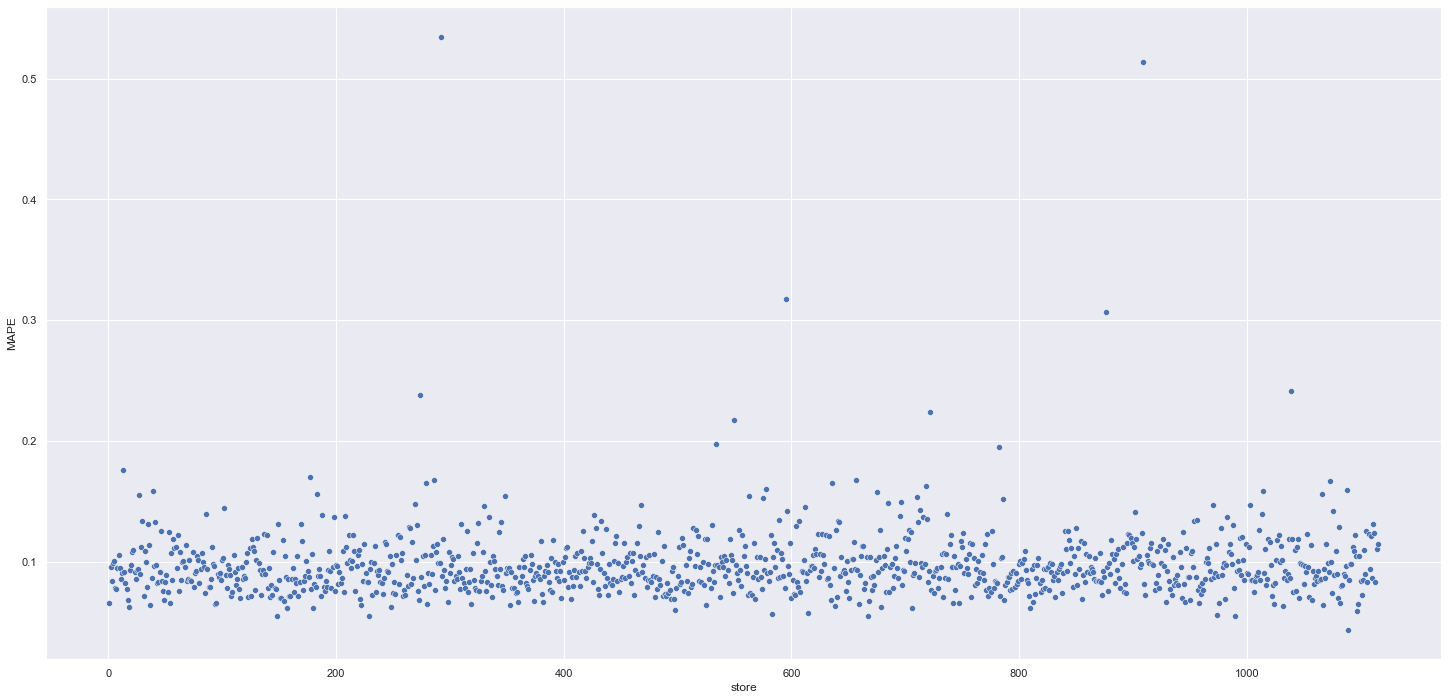

In [211]:
#xgboost 0.90 (atual)
sns.scatterplot( x='store', y='MAPE', data=df92 );

In [ ]:
Notamos acima que a maioria das lojas tem um erro MAPE entre aprox. 7 e 15%.

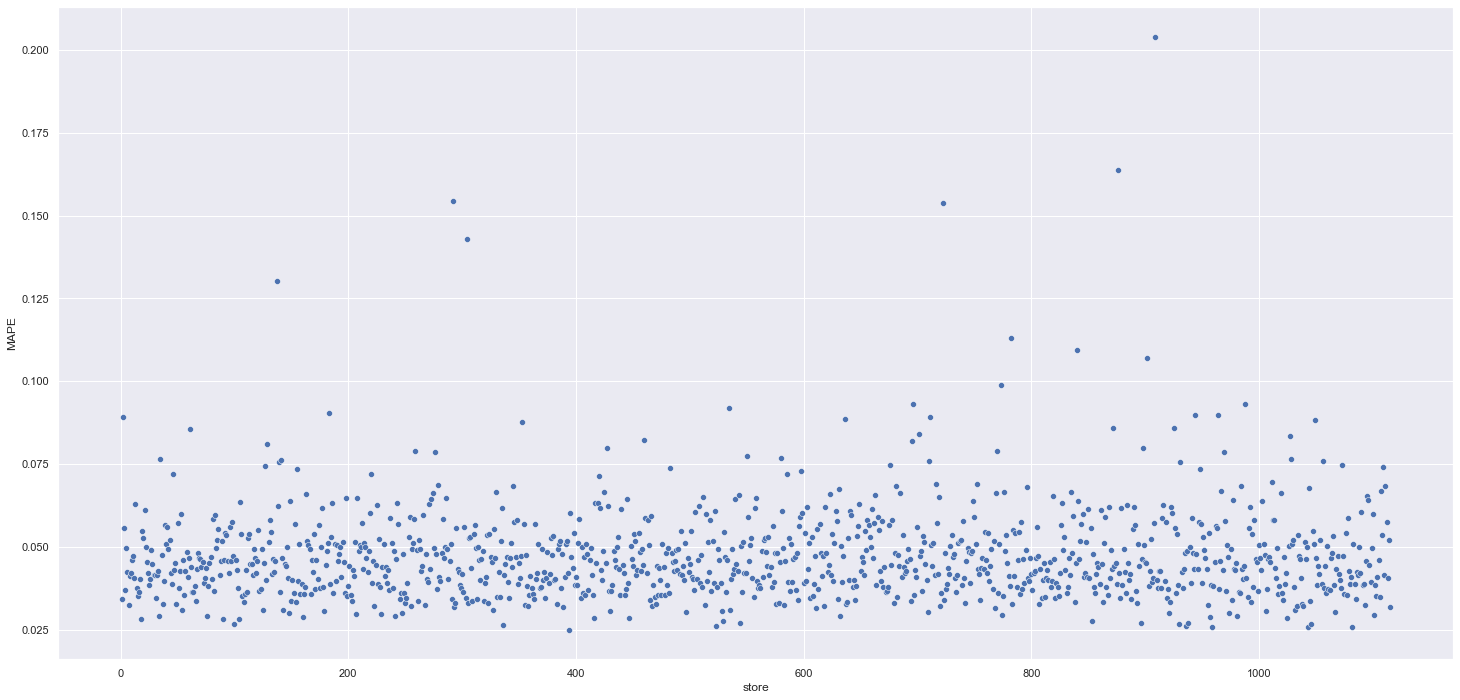

In [243]:
#xgboost 1.5.1 (old)
sns.scatterplot( x='store', y='MAPE', data=df92 );

Notamos acima que a maioria das lojas tem um erro MAPE entre 2,5 e 7,5%.

## Total Performance

Resumir o pior e melhor cenário pra todas as lojas

In [212]:
#xgboost 0.90 (atual)
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply (lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values' } )
df93['Values'] = df93['Values'].map( '$ {:,.2f}'.format )
df93

#Erro médio de 9,65% (MAPE)

,Scenario,Values
0,predictions,"$ 282,878,976.00"
1,worst_scenario,"$ 255,585,281.49"
2,best_scenario,"$ 310,172,640.23"


In [291]:
#xgboost 1.5.1 (old)
#axis=0 - somas das colunas
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply (lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values' } )
df93['Values'] = df93['Values'].map( '$ {:,.2f}'.format )
df93

#Erro médio de 4,65% (MAPE)

,Scenario,Values
0,predictions,"$ 286,958,912.00"
1,worst_scenario,"$ 273,620,969.02"
2,best_scenario,"$ 300,296,882.75"


Melhorando a exibição, por loja:

In [214]:
df94 = df92.copy()

In [215]:
# formata valores monetários em dólares
df94['predictions'] = df94['predictions'].map( '$ {:,.2f}'.format )
df94['worst_scenario'] = df94['worst_scenario'].map( '$ {:,.2f}'.format )
df94['best_scenario'] = df94['best_scenario'].map( '$ {:,.2f}'.format )
df94['MAE'] = df94['MAE'].map( '$ {:,.2f}'.format )

#renomeia colunas MAE e MAPE
df94 = df94.rename( columns= {'MAE':'mean_abs_error', 'MAPE':'mean_abs_perc_error'} )
#traz o erro para o formato: x,xx 
df94['mean_abs_perc_error'] = df94['mean_abs_perc_error'].apply( lambda x: round(x*100,2) ) 

In [217]:
#xgboost 1.5.1 (old)
df94.head()

,store,predictions,worst_scenario,best_scenario,mean_abs_error,mean_abs_perc_error
0,1,"$ 161,804.58","$ 151,077.38","$ 172,531.78",$ 288.95,6.63
1,2,"$ 173,195.28","$ 156,604.65","$ 189,785.91",$ 467.18,9.58
2,3,"$ 253,108.44","$ 231,704.74","$ 274,512.14",$ 588.96,8.46
3,4,"$ 336,624.75","$ 303,221.04","$ 370,028.46","$ 1,019.31",9.92
4,5,"$ 175,882.48","$ 158,086.48","$ 193,678.49",$ 448.73,10.12


## Machine Learning Performance

Olhar em formato gráfico como as vendas se comportam nas 6 semanas previstas (vendas e erros na linha do tempo, muito interessante!)

In [218]:
#colunas usadas pra construir os gráficos
df9['error'] = df9['sales'] - df9['predictions'] 
df9['error_rate'] = df9['predictions'] / df9['sales'] 

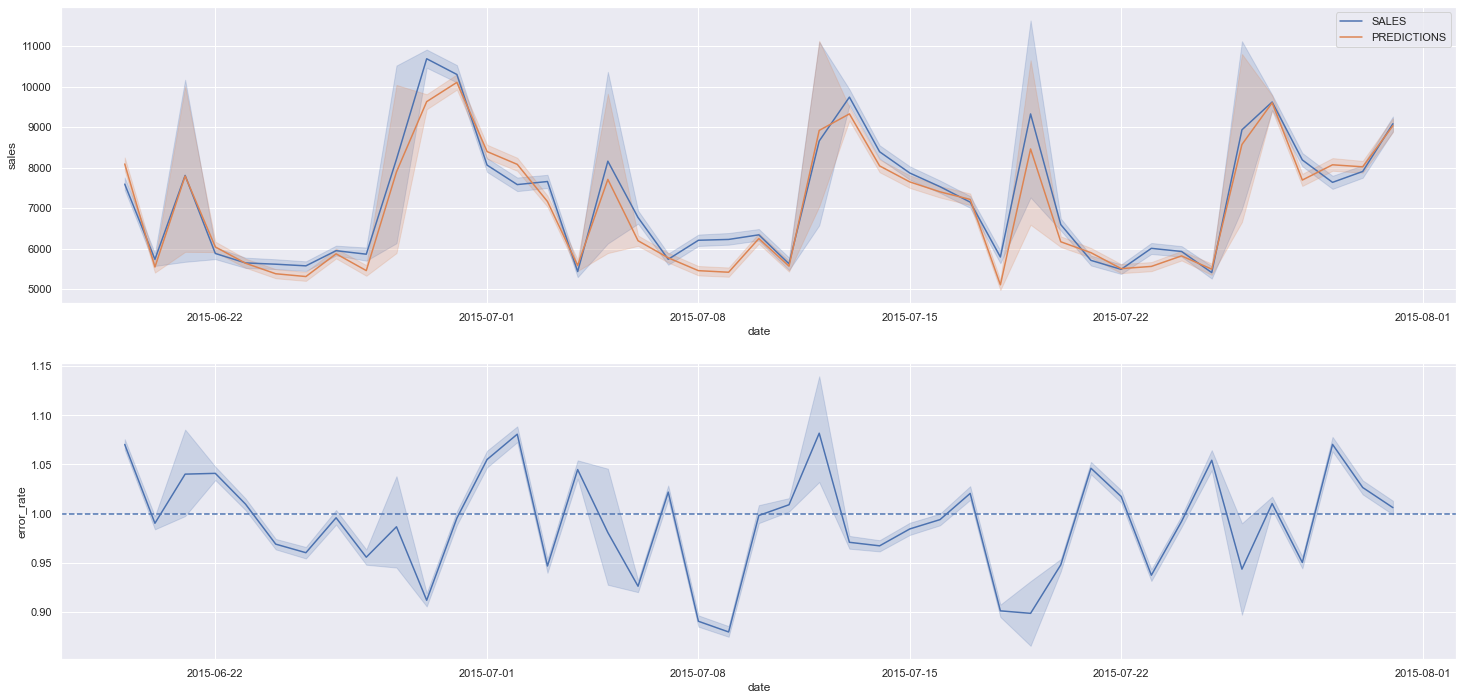

In [219]:
#xgboost 0.90 (atual)

#Nas 6 semanas em que prevemos as vendas: 
    #Vendas reais x vendas previstas pelo GXBoost por dia:
    #A sombra em laranja é a variancia, valor que varia de loja por loja.
    #Notamos que a predição ao longo do tempo está bem próxima das vendas ao longo do tempo.
plt.subplot( 2,1,1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

#Nas 6 semanas em que prevemos as vendas: 
    #Taxa de erros por dia:
    #Quando for = 1, tenho a previsão perfeita.
    #Se variação acima do 1, são dias onde modelo superestimou vendas (predição > venda).
plt.subplot( 2,1,2 )
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--');

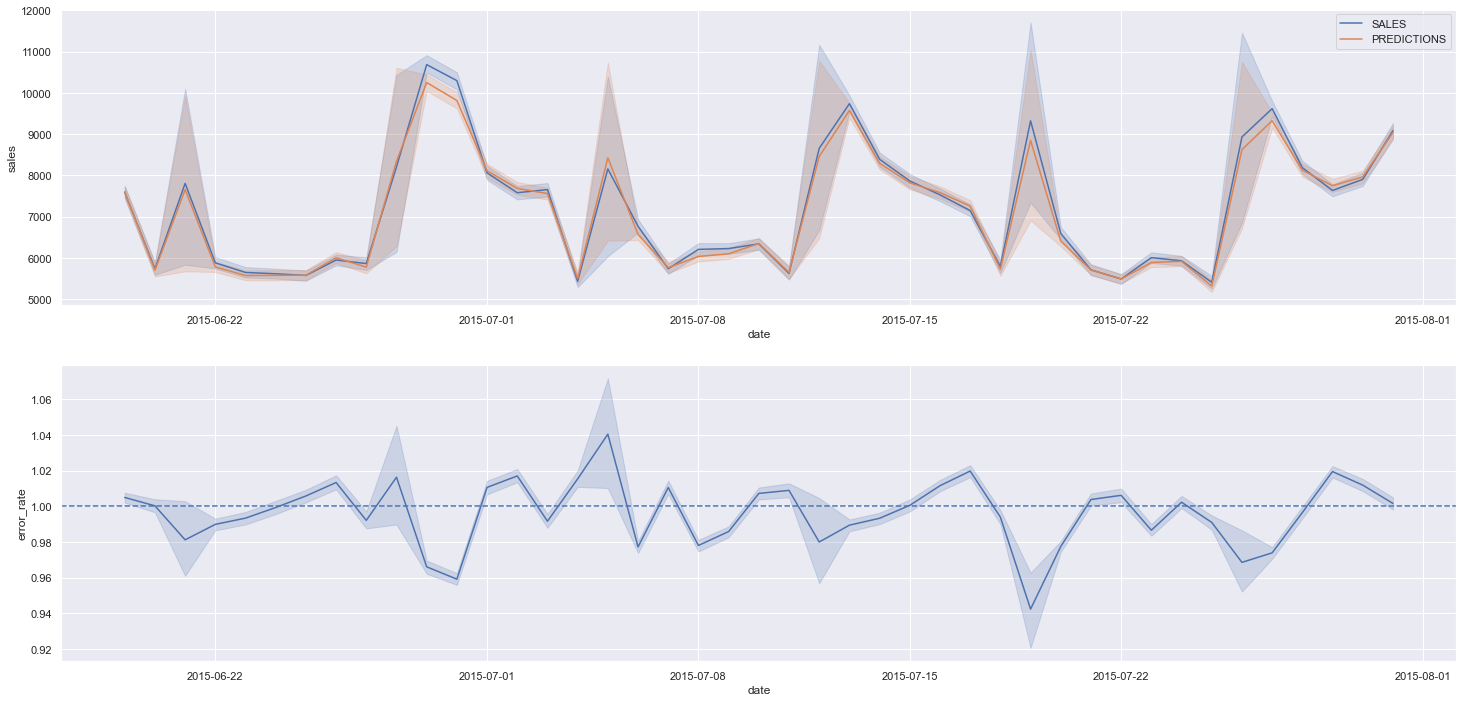

In [254]:
#xgboost 1.5.1 (old)

#Nas 6 semanas em que prevemos as vendas: 
    #Vendas reais x vendas previstas pelo GXBoost por dia:
    #A sombra em laranja é a variancia, valor que varia de loja por loja.
    #Notamos que a predição ao longo do tempo está bem próxima das vendas ao longo do tempo.
plt.subplot( 2,1,1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

#Nas 6 semanas em que prevemos as vendas: 
    #Taxa de erros por dia:
    #Quando for = 1, tenho a previsão perfeita.
    #Se variação acima do 1, são dias onde modelo superestimou vendas (predição > venda).
plt.subplot( 2,1,2 )
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--');

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


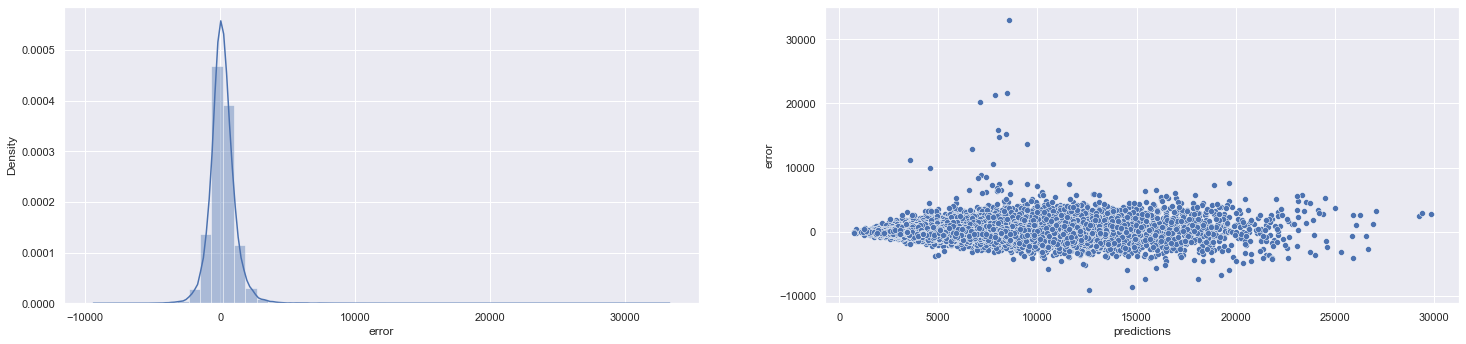

In [221]:
#xgboost 0.90 (atual)

#Plotar a distribuição do erro, para ver se é parecida com uma normal.
    #Se for, isso é bem positivo, é usado para análise do resíduo.
    #Análise de resíduo: aborda quais pontos fracos tem o modelo, para que possa trabalhar nas 
        #melhorias dele.
plt.subplot( 2,2,1 )
sns.distplot( df9['error'] );

#Plotar o gráfico de resíduo.
    #Mostra que previsões entre 10 e 15k de vendas tem erros um pouco maiores que nas demais 
       #faixas, por exemplo. Mas é bem leve, está muito bom. O gráfico precisa ficar dentro de um
       #tubo horizontal, como está o nosso, com alguns outliers é normal, como temos.
    #É usado também para análise do resíduo.
plt.subplot( 2,2,2 )
sns.scatterplot( df9['predictions'], df9['error'] );

/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/home/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


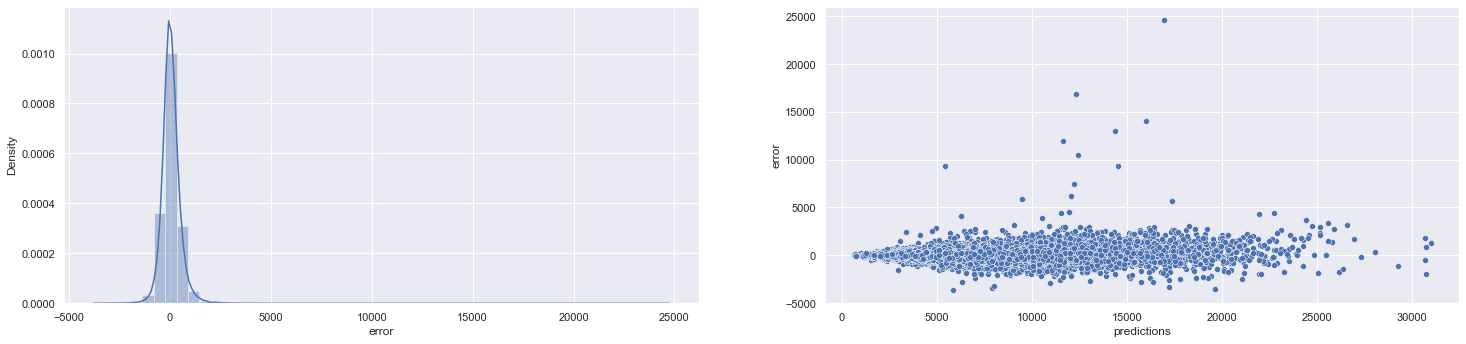

In [256]:
#xgboost 1.5.1 (old)

#Plotar a distribuição do erro, para ver se é parecida com uma normal.
    #Se for, isso é bem positivo, é usado para análise do resíduo.
    #Análise de resíduo: aborda quais pontos fracos tem o modelo, para que possa trabalhar nas 
        #melhorias dele.
plt.subplot( 2,2,1 )
sns.distplot( df9['error'] );

#Plotar o gráfico de resíduo.
    #Mostra que previsões entre 10 e 15k de vendas tem erros um pouco maiores que nas demais 
       #faixas, por exemplo. Mas é bem leve, está muito bom. O gráfico precisa ficar dentro de um
       #tubo horizontal, como está o nosso, com alguns outliers é normal, como temos.
    #É usado também para análise do resíduo.
plt.subplot( 2,2,2 )
sns.scatterplot( df9['predictions'], df9['error'] );